# Описание проекта

**Проект -** "Прогноз риска ДТП"<br>
**Заказчик -** Каршеринговая компания<br>
**Цель проекта** - Разработка системы, прогнозирования риска ДТП по выбранному маршруту движения.
<br>

**Ограничения :**
<br>
* Тип виновника — только машина (car).
* Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
* Для моделирования ограничиться данными за 2012 год — они самые свежие.
* Обязательно учесть возраст автомобиля.

**Структура предоставленных данных (таблицы и поля):**
* `collisions` (информация о происшествиях)
    * CASE_ID	Уникальный номер для зарегистрированного происшествия в таблице происшествий
    * COLLISION_DATE - Дата происшествия
    * COLLISION_TIME - Время происшествия
    * INTERSECTION - Является ли место происшествие перекрёстком
    * WEATHER_1 - Погода
    * COLLISION_DAMAGE - Серьёзность происшествия
    * PRIMARY_COLL_FACTOR - Основной фактор аварии
    * ROAD_SURFACE - Состояние дороги
    * LIGHTING - Освещение
    * COUNTY_CITY_LOCATION - Номер географических районов, где произошло ДТП
    * COUNTY_LOCATION	- Названия географических районов, где произошло ДТП
    * DIRECTION - Направление движения
    * DISTANCE - Расстояние от главной дороги (метры)
    * LOCATION_TYPE - Тип дороги
    * PARTY_COUNT	- Количество участников
    * PCF_VIOLATION_CATEGORY - Категория нарушения	
    * TYPE_OF_COLLISION - Тип аварии
    * MOTOR_VEHICLE_INVOLVED_WITH	- Дополнительные участники ДТП
    * ROAD_CONDITION_1 - Дорожное состояние
    * CONTROL_CONDITION_1	- Устройство управления

* `Parties` (описание участников происшествия)
    * CASE_ID - Уникальный номер для зарегистрированного происшествия в таблице происшествий
    * PARTY_NUMBER - Номер участника происшествия
    * PARTY_TYPE - Тип участника происшествия
    * AT_FAULT - Виновность участника 0/1
    * PARTY_DRUG_PHYSICAL - Состояние участника: физическое или с учётом принятых лекарств
    * PARTY_SOBRIETY - Трезвость участника
    * CELLPHONE_IN_USE - Наличие телефона в автомобиле (возможности разговаривать по громкой связи) 0/1
* `Vehicles` (Описание автомобиля)
    * ID - Номер в таблице
    * CASE_ID - Уникальный номер для зарегистрированного происшествия в таблице происшествий.
    * VEHICLE_TYPE - Тип кузова
    * VEHICLE_TRANSMISSION - Тип КПП
    * VEHICLE_AGE - Возраст автомобиля (в годах)
* `case_ids` (Содержание таблицы не описано)
<br>

**План работы :**
* Подключиться к базе данных
* Провести первичное исследование таблиц
* Провести статистический анализ факторов ДТП
* Загрузить необходимые данные
* Провести исследование и подготовку данных для построения модели
* Разработать модель оценки водительского риска
* Расчитать метрики эффективности модели
* Сделать анализ важности факторов
<br>

# Апгрейд модулей

!pip install phik -q

!pip install matplotlib==3.8.2

pip install scikit-learn==1.6.1

# Импорт библиотек и глобальные установки

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from statistics import median
from sqlalchemy import create_engine

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from phik.report import plot_correlation_matrix

# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import(
                                RandomizedSearchCV,
                                train_test_split
)
from sklearn.metrics import(
                                f1_score,
                                precision_score,
                                recall_score,
                                roc_auc_score,
                                roc_curve,
                                accuracy_score,
                                confusion_matrix,
                                precision_recall_curve
)
from sklearn.linear_model import(
#                                LinearRegression,
                                LogisticRegression
)

from sklearn.preprocessing import (
                                OneHotEncoder,
                                OrdinalEncoder,
                                StandardScaler,
                                MinMaxScaler,
                                RobustScaler
)

In [3]:
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None) # Отображать все поля DF
pd.set_option('display.max_colwidth', None)  # Отображать все содержание полей DF

RANDOM_STATE = 2025

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

color_end = color.END
red_start = color.RED
blue_start = color.BLUE
purple_start = color.PURPLE

# Функции

## `num_fich_by_hue_visualisation` - визуализация зависимостей

In [4]:
def num_fich_by_hue_visualisation(
    data_,
    figsize_ = (7, 5),
    title_ = '',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = '',
    x_rotation_ = 0,
    x_field_ = '',
    y_field_ = '',
    x_label_ = '',
    y_label_ = '',
    hue_field_ = ''
):

    fig, axes = plt.subplots(figsize = figsize_)
    fig.suptitle(title_, fontsize = title_fontsize_, y = y_title_)

    if len(hue_field_) > 0:
        sns.barplot(
                    data = data_,
                    x = x_field_,
                    y = y_field_,
                    hue = hue_field_,
                    palette = 'Set2',
                    alpha = 0.7
        )
        
        axes.legend(title = legend_title_, ncol = 1, loc = 'upper right', frameon = True)
    else:
        sns.barplot(
                    data = data_,
                    x = x_field_,
                    y = y_field_,
                    palette = 'Set2',
                    alpha = 0.7
        )
    axes.set(xlabel = x_label_, ylabel = y_label_)
    
    plt.xticks(rotation = x_rotation_)
    plt.show()

## `categorical_property_visualization` - визуализация категориальных признаков

In [5]:
def categorical_property_visualization(
    data_,
    indexes_=[],
    titles_=[],
    values_='',
    aggfunc_='count',
#    nrows_= 2,
    ncols_= 3,
    figsize_=(20, 7),
    title_ = '',
    y_title_ = 1
):

    nrows_ = math.ceil(len(indexes_) / ncols_)
    
    columns = data_.columns
    record_count = data_.shape[0]
    
    row_ind = 0
    col_ind = 0
    subplot_ind = 0
    
    if nrows_ * ncols_ < len(indexes_):
        print('Несоответствие - nrows_ * ncols_ < len(indexes_)')
        return

    fig, axes = plt.subplots(nrows = nrows_, ncols = ncols_, figsize = figsize_)
    fig.suptitle(title_, fontsize=20, y = y_title_)

    for x in axes.ravel():
        x.axis("off")    
        #print(row_ind, col_ind)
        #print(len(axes.shape))

    for ind in indexes_:
        if len(axes.shape) == 1:
            current_ax = axes[subplot_ind]
        else:
            current_ax = axes[row_ind, col_ind]
        
        for_plot_df = data_.pivot_table(
                index=ind,
                values=values_,
                aggfunc=aggfunc_
            )
        for_plot_df.columns = ['count']
        for_plot_df.plot(
                kind='pie',
                ax = current_ax,
                #y='id',
                y='count',
                autopct='%1.0f%%'
            )

        current_ax.set_title(titles_[subplot_ind])
        current_ax.get_legend().remove()
            
        subplot_ind += 1
        col_ind += 1
        if col_ind == ncols_: #3
            col_ind = 0
            row_ind += 1

## `column_analiser` - визуализация числовых признаков

In [6]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('---------------------------------------------------------------------------------------------------------')
    print(blue_start, f'Поле : {column_} - {x_label}', color_end)
    isna_count = df_[column_].isna().sum()
    print(blue_start, '    Количество пропусков - ', color_end, isna_count)
    print(blue_start, '    Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), '%')
    print('')
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            print('kde_plot_log_flag_ = ', kde_plot_log_flag_)
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

## `df_inf` - информация о дата фрейме

In [7]:
def df_inf(df, head_row=5, drop_duplicates_flag=False):
    print(purple_start, '-------------------------------------------------------------------------', color_end)
    try:
        df_name = df.name
    except:
        df_name = 'Не определено'

    print(blue_start,'Имя:', df_name, color_end)
    print('')
    
    df_shape_ = df.shape
    
    print(blue_start, df_name, '(первые', head_row, 'строк)', color_end)
    display(df.head(head_row))
    print('')
    
    print(blue_start,'Информация: ', color_end)
    df.info()
    print('')

    try:
        print(blue_start,'Описание числовых полей: ', color_end)
        display(df.describe(exclude=['O']))
    except ValueError:
        print(blue_start,'Числовых полей нет!', color_end)
        
    print('')
    
    try:
        print(blue_start,'Описание не числовых полей: ', color_end)
        display(df.describe(include=['O']))
    except ValueError:
        print(blue_start,'Не числовых полей нет!', color_end)
        
    print('')

    print(blue_start,'Пропуски: ', color_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    #isna_record_count  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
    record_count = df_shape_[0]
    isna_record_count  = df[df.isnull().any(axis=1)].shape[0]
    
    print(blue_start, 'Доля записей, содержащих пропуски:',color_end, round((isna_record_count/record_count)*100, 2),'%')
    
    if len(df_duplicates) > 0:
        print(' ')
        print(blue_start,'Количество дубликатов:',len(df_duplicates), color_end)
        print(blue_start,'Дубликаты (первые', head_row, 'строк)', color_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(blue_start,'Дубликаты удалены!', color_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            df_duplicates = df[df.duplicated()]
            print(blue_start,'Количество дубликатов после удаления:',len(df_duplicates), color_end)
    else:
        print(blue_start,'Дубликаты не обнаружены!', color_end)
    print(' ')
    return df_duplicates, df_shape_

## `check_categorical_fields` - вывод уникальных значений полей

In [8]:
def check_categorical_fields(df_, fields_lst, print_unique_val=False):
    record_count = df_.shape[0]
    for field in fields_lst:
        print('---------------------------------------------------------------------------------------------------------')
        print(blue_start, 'Поле - ', color_end, field)
        print(blue_start, 'Количество уникальных значений -  ', color_end, len(df_[field].unique()))

        isna_count = df_[field].isna().sum()
        print(blue_start, 'Количество пропусков - ', color_end, isna_count)
        if isna_count > 0:
            print(
                blue_start,
                'Доля пропусков - ',
                color_end,
                round((isna_count / record_count) * 100, 2),
                blue_start,
                '%',
                color_end
                 )
        print('')
        if print_unique_val:
            with pd.option_context("display.max_rows", None):
                unique_count_df = pd.DataFrame(df_[field].value_counts().sort_index(ascending = True)).reset_index()
                unique_count_df.columns = ['Значение', 'Количество']
                display(unique_count_df)

## `get_day_part` - определение времени суток по часу

In [9]:
def get_day_part(hour):
    day_part = 'not_state'
    if 0 <= hour < 6:
        day_part = 'night'
    elif 6 <= hour < 12:
        day_part = 'morning'
    elif 12 <= hour < 18:
        day_part = 'afternoon'
    elif 18 <= hour < 24:
        day_part = 'evening'
    return day_part

## `my_fillna` - заполнение пустых значений по агрегированному значению определенного поля 

In [10]:
# df_ - фрейм данных
# filter_value - значение для фильтрации
# filtered_field - поле фильтрации
# filled_field - заполняемое поле
# fill_function - функция агрегации

def my_fillna(
    df_,
    filter_value_,
    filtered_field_,
    filled_field_,
    fill_function
):

#    print('filter_value_ = ', filter_value_)
#    print('filtered_field_ = ', filtered_field_)
#    print('filled_field_ = ', filled_field_)

    fill_val = np.nan
# Расчет значения для заполнения    
    if fill_function == 'mode':
        fill_val = df_[filled_field_].loc[df_[filtered_field_] == filter_value_].mode().values[0]
    elif fill_function == 'median':
        fill_val = df_[filled_field_].loc[df_[filtered_field_] == filter_value_].median()
    elif fill_function == 'mean':
        fill_val = df_[filled_field_].loc[df_[filtered_field_] == filter_value_].mean()

#    print(fill_val)
#    print('')


# Заполнение поля с пропусками значением fill_val
    df_[filled_field_].loc[(df_[filtered_field_] == filter_value_) & (df_[filled_field_].isna())] = fill_val

## `run_sql` - формирование фрейма данных по результатам выполнения sql-скрипта

In [11]:
def run_sql(query_text):
    engine = create_engine(connection_string)
    sql_df = pd.read_sql_query(query_text, con = engine)
    engine.dispose()
    return sql_df

# **`Подключение к базе, первичное исследование таблиц.`**

## Подключение к базе данных

In [12]:
db_config = {
'user': '', # имя пользователя,
'pwd': '', # пароль,
'host': '',
'port': , # порт подключения,
'db': '' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

## Формирование данных полей для сравнения документации по проекту и базы данных

## Формирование датасета, содержащего информацию о таблицах по документации

In [13]:
# Имена полей скопированны из описания таблиц в проекте

collisions_doс_columns_lst = [
    'CASE_ID',
    'COLLISION_DATE',
    'COLLISION_TIME',
    'INTERSECTION',
    'WEATHER_1',
    'COLLISION_DAMAGE',
    'PRIMARY_COLL_FACTOR',
    'ROAD_SURFACE',
    'LIGHTING',
    'COUNTY_CITY_LOCATION',
    'COUNTY_LOCATION',
    'DIRECTION',
    'DISTANCE',
    'LOCATION_TYPE',
    'PARTY_COUNT',
    'PCF_VIOLATION_CATEGORY',
    'TYPE_OF_COLLISION',
    'MOTOR_VEHICLE_INVOLVED_WITH',
    'ROAD_CONDITION_1',
    'CONTROL_CONDITION_1'
]

parties_doс_columns_lst = [
    'CASE_ID',
    'PARTY_NUMBER',
    'PARTY_TYPE',
    'AT_FAULT',
    'INSURANCE_PREMIUM',
    'PARTY_DRUG_PHYSICAL',
    'PARTY_SOBRIETY',
    'CELLPHONE_IN_USE'
]
vehicles_doс_columns_lst = [
    'ID',
    'CASE_ID',
    'VEHICLE_TYPE',
    'VEHICLE_TRANSMISSION',
    'VEHICLE_AGE'
]
case_ids_doс_columns_lst =[
    'case_id',
    'db_year'
]

# трансформация имен полей в нижний регистр
collisions_doс_columns_lst = [s.lower() for s in collisions_doс_columns_lst]
parties_doс_columns_lst = [s.lower() for s in parties_doс_columns_lst]
vehicles_doс_columns_lst = [s.lower() for s in vehicles_doс_columns_lst]

In [14]:
collisions_doс_columns_series = pd.Series('collisions', collisions_doс_columns_lst)
parties_doс_columns_series = pd.Series('parties', parties_doс_columns_lst)
vehicles_doс_columns_series = pd.Series('vehicles', vehicles_doс_columns_lst)
case_ids_doс_columns_series = pd.Series('case_ids', case_ids_doс_columns_lst)

In [15]:
# Объединенный список полей по документации
doс_columns_series = pd.concat(
    [
        collisions_doс_columns_series,
        parties_doс_columns_series,
        vehicles_doс_columns_series,
        case_ids_doс_columns_series
    ],
    axis = 0)

In [16]:
## Датасет, содержащий информацию о таблицах по документации
crash_tables_doc_info_df = pd.DataFrame(data = doс_columns_series).reset_index()
crash_tables_doc_info_df.columns = ['column_name', 'table_name']
crash_tables_doc_info_df['from_doc'] = 'yes'

## Формирование датасета, содержащего информацию о таблицах по базе данных

In [17]:
query = '''
SELECT
    tables.table_name,
    columns.column_name,
    columns.data_type
FROM
    information_schema.tables AS tables -- Список таблиц
    INNER JOIN information_schema.columns AS columns ON tables.table_name = columns.table_name -- Список полей таблиц
WHERE
    tables.table_schema = 'public'
    AND tables.table_type = 'BASE TABLE'
ORDER BY
    tables.table_name,
    columns.is_identity,
    columns.column_name
'''

crash_tables_info_df = run_sql(query)

crash_tables_info_df['from_db'] = 'yes'

## Сравнение описаннои и фактичесткой структкры данных

In [18]:
# Объединение описание таблиц по документации и из базы данных
doc_fact_data_structure_df = pd.merge(
    crash_tables_info_df,
    crash_tables_doc_info_df,
    on = ['table_name', 'column_name'],
    how = "outer"
                                     ).sort_values(by = 'table_name')

In [19]:
# Несоответствие названий полей в базе и документации по проекту
doc_fact_data_structure_df.query(
    'from_db.isna() or from_doc.isna()'
                                ) \
[
    ['table_name', 'column_name', 'from_db', 'from_doc']
].fillna('NO').sort_values(by = ['table_name', 'column_name'])

,table_name,column_name,from_db,from_doc
38,collisions,control_condition_1,NO,yes
6,collisions,control_device,yes,NO
37,collisions,primary_coll_factor,NO,yes
17,collisions,primary_collision_factor,yes,NO
25,parties,id,yes,NO
33,vehicles,party_number,yes,NO


## Первичное исследование таблиц

In [20]:
for current_table in crash_tables_info_df['table_name'].unique():
    query = '''
    SELECT
        *
    FROM ''' + current_table + '''
    LIMIT 3
    '''
    result_df = run_sql(query)
    print(blue_start, 'Таблица - ', color_end, current_table)
    print(blue_start, '----------------------------------------------------------------------------------', color_end)
    #display(pd.read_sql_query(query, con=engine))
    display(result_df)
    print()

 Таблица -   case_ids
 ---------------------------------------------------------------------------------- 


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021



 Таблица -   collisions
 ---------------------------------------------------------------------------------- 


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00



 Таблица -   parties
 ---------------------------------------------------------------------------------- 


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29,had not been drinking,None,0
1,23,3899454,2,road signs,0,7,had not been drinking,None,0
2,29,3899462,2,car,0,21,had not been drinking,None,0



 Таблица -   vehicles
 ---------------------------------------------------------------------------------- 


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3


## **`Выводы`**

* Реализовано подключение к БД
* Перечень таблиц соответствует описанию
* Таблицы содержат данные
* Ключи для объединения таблиц:
|Таблицы|Ключ|
|-----------|----------:|
|`collisions` и `parties`|`case_id`|
|`collisions` и `vehicles`|`case_id`|
|`parties` и `vehicles`|`case_id` + `party_number`|
* Обнаружены отличия в составе полей по описанию и БД:
|Таблица|Поле|По БД|По описанию|
|-----------|----------|---------|---------|
|collisions|control_condition_1|NO|yes|
|collisions|control_device|yes|NO|
|collisions|primary_coll_factor|NO|yes|
|collisions|primary_collision_factor|yes|NO|
|parties|id|yes|NO|
|vehicles|party_number|yes|NO|
<br>

* Значимым отличием фактической структуры от описание является наличие поля `party_number` в таблице `vehicles`
* Ключей для объединения таблиц достаточно

# **`Статистический анализ факторов ДТП`**

## Количество ДТП по годам и месяцам.

In [21]:
query = '''
SELECT
    EXTRACT(YEAR FROM collisions.collision_date)::int as collision_year,
    EXTRACT(MONTH FROM collisions.collision_date)::int as collision_month,    
    count(*) collision_count
FROM
    collisions
WHERE
    collisions.collision_damage != 'scratch'
    AND EXISTS(
            SELECT 1
            FROM
                parties
            WHERE
                party_type = 'car'
                AND collisions.case_id = parties.case_id
    )
GROUP BY
    collision_year,
    collision_month
ORDER BY
    collision_year,
    collision_month
'''

collisions_inf_df = run_sql(query)

 Год -  2009 
 Максимальное количество ДТП -  28135  произошло в  10  месяце. 


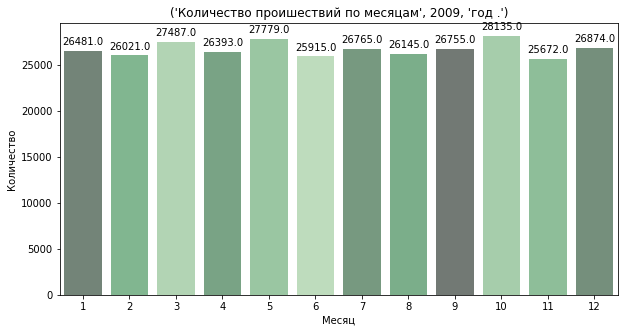

 Год -  2010 
 Максимальное количество ДТП -  27962  произошло в  10  месяце. 


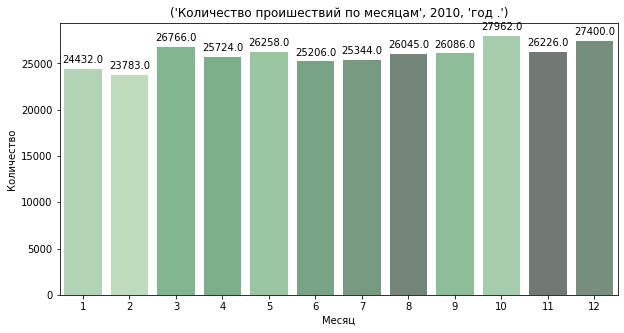

 Год -  2011 
 Максимальное количество ДТП -  27120  произошло в  10  месяце. 


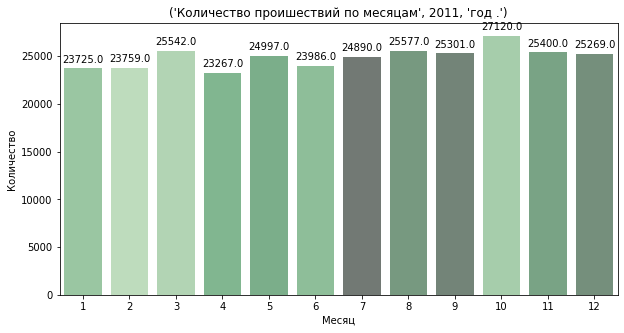

 Год -  2012 
 Максимальное количество ДТП -  23962  произошло в  3  месяце. 


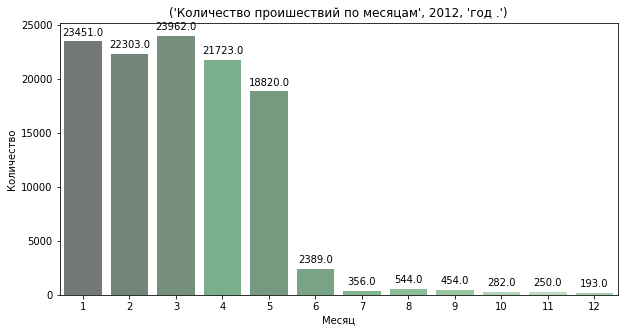

 Год -  2013 
 Максимальное количество ДТП -  141  произошло в  1  месяце. 


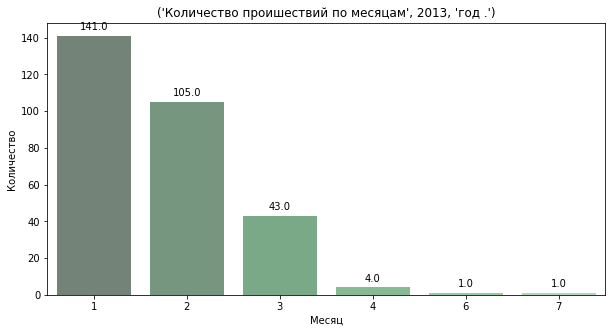

 Год -  2020 
 Максимальное количество ДТП -  1  произошло в  7  месяце. 


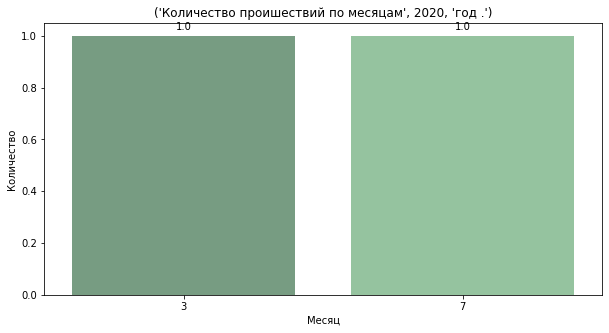

In [22]:
# Графики количества ДТП по годам и месяцам
year_range = collisions_inf_df['collision_year'].unique()

for current_year in year_range: # range(collisions_inf_df['collision_year'].min(), collisions_inf_df['collision_year'].max() + 1):

    current_year_df = collisions_inf_df.query('collision_year == @current_year').sort_values(by = 'collision_month', ascending=False)
    max_collision = current_year_df['collision_count'].max()
    max_collision_month = current_year_df['collision_month'].loc[current_year_df['collision_count'] == max_collision].max()
    
    print(blue_start, 'Год - ', current_year, color_end)
    print(
        blue_start, 'Максимальное количество ДТП -', color_end,
        max_collision, blue_start, 'произошло в', color_end,
        max_collision_month, blue_start, 'месяце.', color_end
         )

    pal = sns.color_palette('Greens_d', len(current_year_df))
    rank = current_year_df['collision_count'].argsort()
    
    fig, axes = plt.subplots(figsize=(10, 5))
    
    splot = sns.barplot(data = current_year_df,
                x = 'collision_month',
                y = 'collision_count',
                alpha = 0.7,
                palette = np.array(pal[::-1])[rank],
                label = 'Количество проишествий', axes = axes)
    axes.set(xlabel = 'Месяц', ylabel = 'Количество')
    
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    title_str = 'Количество проишествий по месяцам', current_year, 'год .'
    plt.title(title_str)
    plt.show()

## Определение периода для дальнейшей работы

In [23]:
DATE_YEAR_LST = ['2012']# ['2009', '2010', '2011']

# Формирование строки для использования в SQL-запросах
DATE_YEAR_STR = '(' + ', '.join(DATE_YEAR_LST) + ')'
DATE_YEAR_STR

'(2012)'

## **`Выводы`**

* Предоставленные данные содержат информацию о ДТП за периоды:
    * с 2009 по 2011 года по 12ти месяцам, **равномерное распределение данных по месяцам**.
    * 2012 год по 12ти месяцам, не равномерное распределение данных по месяцам.
    * 2013 год по 7ми месяцам, не равномерное распределение данных по месяцам.
    * 2020 год 3 и 7 месяцы, по одному ДТП.
* **~Период для дальнейшей работы с 2009 по 2011 включительно, т.к. для этого периода представленно максимальное количество данных, равномерно распределенное по месяцам.~**
* Период для формирования модели - 2021 год.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выполнен анализ динамики ДТП по месяцам. Молодец, что отмечаешь неполноту данных.

## **`Аналитические задачи`**

* определить зависимость серьёзности повреждений транспортного средства и состояния дороги в момент ДТП (связать collisions и parties)
* определить зависимость между количеством ДТП и погодой (таблица collisions)
* распределение количества ДТП по типу кузова и трансмиссии виновника (таблицы collisions, parties, vehicle)
* распределение количества ДТП по типу трансмиссии виновника и состоянию дороги (таблицы collisions, parties, vehicle)
* распределение Количества ДТП по степени опьянения виновника. (таблицы collisions, parties, vehicle)
* определить зависимость между количеством ДТП и состоянием дороги (таблица collisions)
* определить зависимость серьёзности повреждений и трезвости участника ДТП (таблицы collisions и parties)
* определить зависимость количества ДТП и возраста автомобилей (таблица vehicle)
* определить количество ДТП по типам трансмиссии в зависимости от состояния дороги (таблицы collisions и vehicle)
* определить количество ДТП по типам кузова(таблицы collisions и vehicle)
* определить количество ДТП по причинам ДТП (таблица collisions)
* определить количество ДТП по районам (таблица collisions)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Задачи для анализа сформулированы.

### Единый план решения задач

* Создайте sql-запрос
    * При выводе значений категориальных признаков, пустые значению необходимо заменить на 'not_state'
* Постройте график
    * Визуализацию результатов запроса необходимо реализовать с использованием функции `num_fich_by_hue_visualisation`
* Сделайте вывод

### Примеры решений

In [24]:
print(blue_start, 'Количеество исследуемых ДТП: ', color_end)
query = '''
SELECT
    COUNT(*)
FROM
    collisions
WHERE
    collisions.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM collisions.collision_date)::int in ''' + DATE_YEAR_STR

collisions_inf_df = run_sql(query)
collisions_inf_df

 Количеество исследуемых ДТП:  


,count
0,115666


#### Распределение количества ДТП по типу трансмиссии виновника и состоянию дороги.

In [25]:
query = '''
SELECT
    COALESCE(collisions.road_surface, 'not_state') AS road_surface,
    COALESCE(Vehicles.vehicle_transmission, 'not_state') AS vehicle_transmission,
    count(*) AS collision_count
FROM
    Vehicles INNER JOIN parties ON 
        Vehicles.case_id = parties.case_id
        AND Vehicles.party_number = parties.party_number
    INNER JOIN collisions ON Vehicles.case_id = collisions.case_id
WHERE
    collisions.collision_damage != 'scratch'
--    AND parties.party_type = 'car'
    AND parties.AT_FAULT = 1
    AND EXTRACT(YEAR FROM collisions.collision_date)::int in ''' + DATE_YEAR_STR
query = query + '''
GROUP BY
    road_surface,
    vehicle_transmission
ORDER BY
    collision_count DESC,
    road_surface,
    vehicle_transmission
'''
collisions_inf_df = run_sql(query)

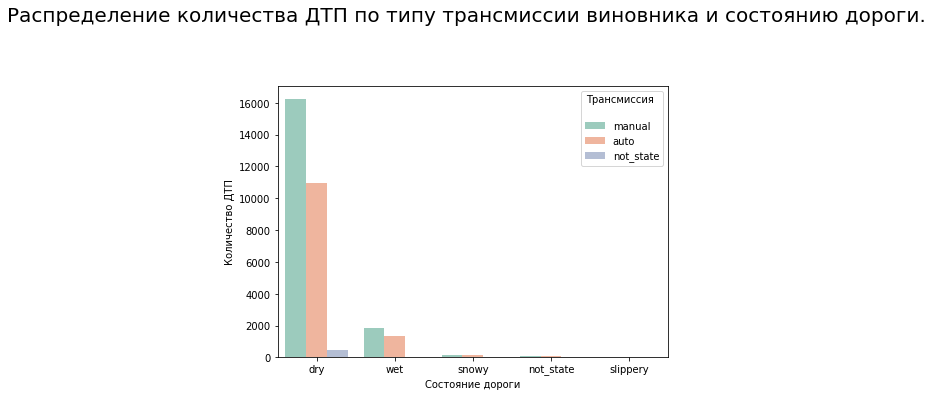

In [26]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Распределение количества ДТП по типу трансмиссии виновника и состоянию дороги.',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Трансмиссия \n',
    x_rotation_ = 0,
    x_field_ = 'road_surface',
    y_field_ = 'collision_count',
    x_label_ = 'Состояние дороги',
    y_label_ = 'Количество ДТП',
    hue_field_ = 'vehicle_transmission'
)

#### Распределение количества ДТП по типу кузова и трансмиссии виновника.

In [27]:
query = '''
SELECT
    COALESCE(Vehicles.vehicle_type, 'not_state') AS vehicle_type,
    COALESCE(Vehicles.vehicle_transmission, 'not_state') AS vehicle_transmission,
    count(*) AS collision_count
FROM
    Vehicles INNER JOIN parties ON 
        Vehicles.case_id = parties.case_id
        AND Vehicles.party_number = parties.party_number
    INNER JOIN collisions ON Vehicles.case_id = collisions.case_id
WHERE
    collisions.collision_damage != 'scratch'
--    AND parties.party_type = 'car'
    AND parties.AT_FAULT = 1
    AND EXTRACT(YEAR FROM collisions.collision_date)::int in ''' + DATE_YEAR_STR
query = query + '''
GROUP BY
    vehicle_type,
    vehicle_transmission
ORDER BY
    collision_count DESC,
    vehicle_type,
    vehicle_transmission
'''
collisions_inf_df = run_sql(query)

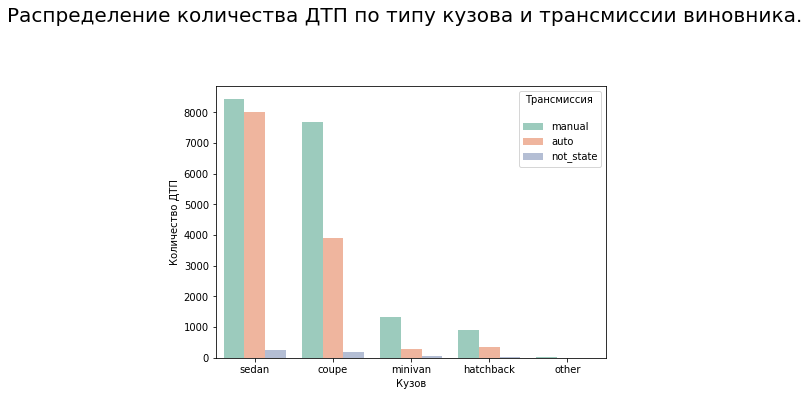

In [28]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Распределение количества ДТП по типу кузова и трансмиссии виновника.',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Трансмиссия \n',
    x_rotation_ = 0,
    x_field_ = 'vehicle_type',
    y_field_ = 'collision_count',
    x_label_ = 'Кузов',
    y_label_ = 'Количество ДТП',
    hue_field_ = 'vehicle_transmission'
)

#### Анализ серьёзности повреждений транспортного средства по состояниюдороги.

In [29]:
query = '''
SELECT
    COALESCE(collisions.collision_damage, 'not_state') AS collision_damage,
    COALESCE(collisions.road_surface, 'not_state') AS road_surface,
    count(*) AS collision_count
FROM
    collisions
WHERE
    collisions.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM collisions.collision_date)::int in ''' + DATE_YEAR_STR
query = query + '''
    AND EXISTS(
            SELECT 1
            FROM
                parties
            WHERE
                party_type = 'car'
                AND collisions.case_id = parties.case_id
    )
GROUP BY
    collision_damage,
    road_surface
ORDER BY
    collision_count DESC,
    collision_damage,
    road_surface
'''
collisions_inf_df = run_sql(query)

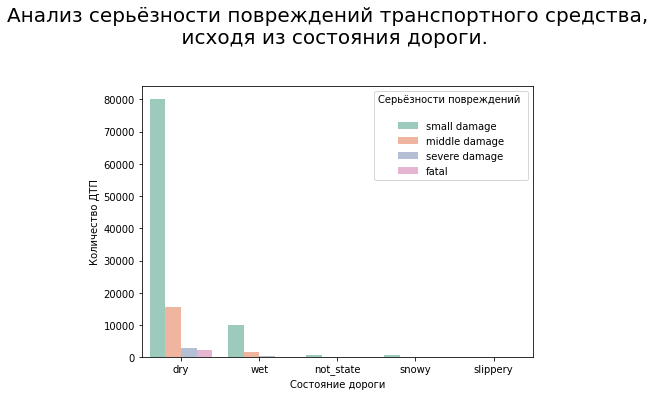

In [30]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Анализ серьёзности повреждений транспортного средства, \n исходя из состояния дороги.',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Cерьёзности повреждений \n',
    x_rotation_ = 0,
    x_field_ = 'road_surface',
    y_field_ = 'collision_count',
    x_label_ = 'Состояние дороги',
    y_label_ = 'Количество ДТП',
    hue_field_ = 'collision_damage'
)

#### Распределение количества ДТП по погоде.

In [31]:
query = '''
SELECT
    COALESCE(collisions.weather_1, 'not_state') AS weather,
    count(*) AS collision_count
FROM
    collisions
WHERE
    collisions.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM collisions.collision_date)::int IN ''' + DATE_YEAR_STR
query = query + '''
    AND EXISTS(
        SELECT 1
        FROM
            parties
        WHERE
            party_type = 'car'
            AND collisions.case_id = parties.case_id
    )
GROUP BY
    weather
ORDER BY
    collision_count DESC
'''

collisions_inf_df = run_sql(query)

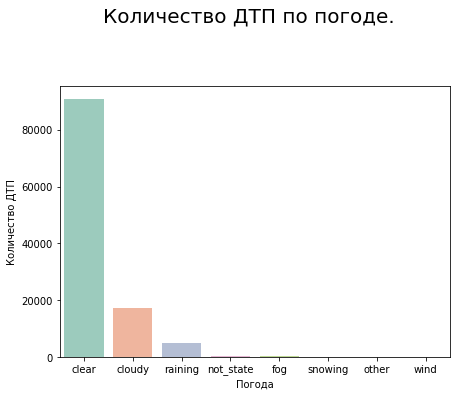

In [32]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Количество ДТП по погоде.',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Состояние покрытия \n',
    x_rotation_ = 0,
    x_field_ = 'weather',
    y_field_ = 'collision_count',
    x_label_ = 'Погода',
    y_label_ = 'Количество ДТП',
    hue_field_ = ''
)

#### Количество ДТП по степени опьянения виновника.

In [33]:
query = '''
SELECT
    COALESCE(party_sobriety, 'not_state') AS party_sobriety,
    count(*) AS collision_count
FROM
    parties INNER JOIN collisions ON parties.case_id = collisions.case_id
WHERE
    parties.party_type = 'car'
    AND collisions.collision_damage != 'scratch'
    AND parties.AT_FAULT = 1
    AND EXTRACT(YEAR FROM collisions.collision_date)::int in ''' + DATE_YEAR_STR
query = query + '''
GROUP BY
    party_sobriety
ORDER BY
    collision_count DESC
'''
collisions_inf_df = run_sql(query)
#collisions_inf_df

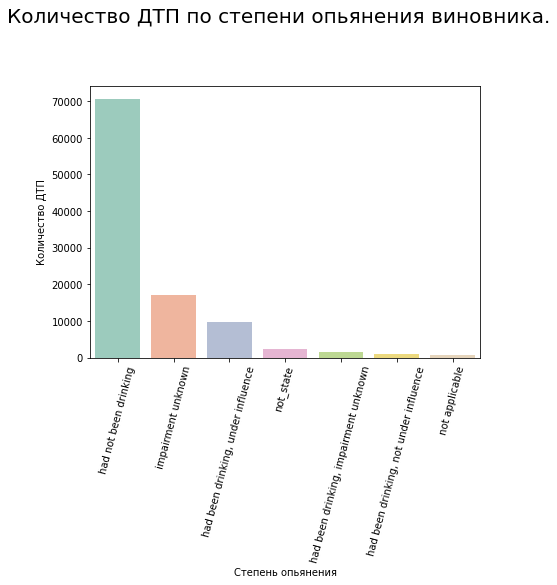

In [34]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Количество ДТП по степени опьянения виновника.',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = '',
    x_rotation_ = 75,
    x_field_ = 'party_sobriety',
    y_field_ = 'collision_count',
    x_label_ = 'Степень опьянения',
    y_label_ = 'Количество ДТП',
    hue_field_ = ''
)

### **`Выводы`**

**Результаты решения аналитических задач указывают на то, что максимальное количество ДТП происходит по вине трезвых водителей, в хорошую погоду, на сухой дороге. Чаще всего в аварии попадают седаны и купе. Автомобили с механической трансмиссией чаще становятся участниками ДТП.**

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследовано несколько задач.

# **`Выбор факторов. Формирование датафрейма для построения модели.`**

## **Выбор факторов.**

**Выбор факторов обусловлен возможностью определения их значения во время оформления аренда автомобиля и требованиями заказчика:**

**Обязательное требование заказчика:**
    * at_fault - Целевой признак
    * vehicle_age - возраст автомобиля

* Служебные признаки - ключи, которые не используются в работе модели:
    * case_id
    * parties_id
    * vehicles_id

**Факторы, отобранные для построения модели:**
* `insurance_premium` - Размер страховой премии. Возможно увеличение размера ответственности заставить водителя управлять автомобилем аккуратнее.
* `party_sobriety` - Степень опьянения. Известный факт - высокая степень опьянения сильно влияет на качество управления автомобилем. **Определяется на месте аварии**, на старте маршрута состояние может отличаться.
* `cellphone_in_use` - наличие системы громкой связи.
        
* `direction` - направление движения. 
         
* `weather` - погодные условия
* `location_type` - тип дороги

* `road_surface` - Состояние дороги (Сухая, мокрая)
* `road_condition` - Дорожное состояние (ямы, ремонт, ровная)
* `lighting` - Освещение

* `collision_year` - год (для проверки полноты выгрузки)
* `collision_month` - месяц (оценка сезонности)
* `collision_dow` - день недели (распределение ДТП по выходным и будним дням)
* `collision_hour` - час (распределение ДТП по времени суток - утро, день, вечер, ночь)
* `vehicle_type` - тип кузова
* `vehicle_transmission` - трансмиссия

## Выгрузка данных

In [35]:
query ='''
SELECT   
    vehicles.id as vehicles_id,
    parties.id as parties_id,
    parties.case_id,
    parties.at_fault,
    parties.insurance_premium,
    
    parties.party_sobriety,   -- Определяется на месте аварии, на старте маршрута состояние может отличаться
--    COALESCE(parties.party_drug_physical, 'not_state') AS party_drug_physical, -- Определяется на месте аварии, на старте маршрута состояние может отличаться
         
    COALESCE(
                CASE
                    WHEN cellphone_in_use = 1 THEN 'yes'
                    WHEN cellphone_in_use = 0 THEN 'no'
                END, 'not_state'
        ) AS cellphone_in_use,
        
--    collisions.distance,
    COALESCE(collisions.direction, 'not_state') AS direction,
         
    collisions.weather_1 AS weather,
    COALESCE(collisions.location_type, 'not_state') AS location_type,

    collisions.road_surface,
    collisions.road_condition_1 AS road_condition,
    collisions.lighting,

    EXTRACT(YEAR FROM collisions.collision_date)::int as collision_year,
    EXTRACT(MONTH FROM collisions.collision_date)::int as collision_month,
    EXTRACT(DOW FROM collisions.collision_date)::int as collision_dow,
    EXTRACT(HOUR FROM collisions.collision_time)::int as collision_hour,
    COALESCE(vehicles.vehicle_type, 'not_state') AS vehicle_type,
    COALESCE(vehicles.vehicle_transmission, 'not_state') AS vehicle_transmission,
    vehicles.vehicle_age
FROM
    parties INNER JOIN vehicles ON 
        parties.case_id = vehicles.case_id
        AND parties.party_number = vehicles.party_number
    INNER JOIN collisions ON
        parties.case_id = collisions.case_id 
WHERE
    collisions.collision_damage != 'scratch'
    AND parties.party_type = 'car'
    AND EXTRACT(YEAR FROM collisions.collision_date)::int IN ''' + DATE_YEAR_STR

# Формирование основного датафрейма
crash_df = run_sql(query)
crash_df.head(3)

,vehicles_id,parties_id,case_id,at_fault,insurance_premium,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,collision_year,collision_month,collision_dow,collision_hour,vehicle_type,vehicle_transmission,vehicle_age
0,1463632,2657076,5599528,0,34.0,had not been drinking,no,west,clear,highway,dry,normal,daylight,2012,4,5,13.0,sedan,auto,4.0
1,1463713,2657345,5599684,0,46.0,had not been drinking,no,south,clear,not_state,dry,normal,daylight,2012,4,0,17.0,sedan,auto,2.0
2,1463913,2657829,5599941,1,38.0,"had been drinking, under influence",no,east,clear,intersection,dry,other,dark with no street lights,2012,5,2,0.0,sedan,auto,5.0


## Информация о датафрейме

In [36]:
crash_df.name = 'crash_df'
duplicates_df, original_shape_df = df_inf(crash_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------- 
 Имя: crash_df 

 crash_df (первые 3 строк) 


,vehicles_id,parties_id,case_id,at_fault,insurance_premium,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,collision_year,collision_month,collision_dow,collision_hour,vehicle_type,vehicle_transmission,vehicle_age
0,1463632,2657076,5599528,0,34.0,had not been drinking,no,west,clear,highway,dry,normal,daylight,2012,4,5,13.0,sedan,auto,4.0
1,1463713,2657345,5599684,0,46.0,had not been drinking,no,south,clear,not_state,dry,normal,daylight,2012,4,0,17.0,sedan,auto,2.0
2,1463913,2657829,5599941,1,38.0,"had been drinking, under influence",no,east,clear,intersection,dry,other,dark with no street lights,2012,5,2,0.0,sedan,auto,5.0



 Информация:  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicles_id           56248 non-null  int64  
 1   parties_id            56248 non-null  int64  
 2   case_id               56248 non-null  object 
 3   at_fault              56248 non-null  int64  
 4   insurance_premium     55701 non-null  float64
 5   party_sobriety        55376 non-null  object 
 6   cellphone_in_use      56248 non-null  object 
 7   direction             56248 non-null  object 
 8   weather               56080 non-null  object 
 9   location_type         56248 non-null  object 
 10  road_surface          55900 non-null  object 
 11  road_condition        55999 non-null  object 
 12  lighting              56094 non-null  object 
 13  collision_year        56248 non-null  int64  
 14  collision_month       56248 non-null  int64  
 15  col

,vehicles_id,parties_id,at_fault,insurance_premium,collision_year,collision_month,collision_dow,collision_hour,vehicle_age
count,5.624800e+04,5.624800e+04,56248.000000,55701.000000,56248.0,56248.000000,56248.000000,56160.000000,54554.000000
mean,1.429235e+06,2.594616e+06,0.504427,37.607170,2012.0,3.233786,3.154974,13.318145,4.856472
std,5.439976e+04,9.877649e+04,0.499985,16.328721,0.0,1.808481,2.049480,5.526344,3.234503
min,9.855270e+05,1.800807e+06,0.000000,0.000000,2012.0,1.000000,0.000000,0.000000,0.000000
25%,1.386473e+06,2.517333e+06,0.000000,24.000000,2012.0,2.000000,1.000000,10.000000,3.000000
50%,1.432047e+06,2.598362e+06,1.000000,34.000000,2012.0,3.000000,3.000000,14.000000,4.000000
75%,1.476086e+06,2.681091e+06,1.000000,49.000000,2012.0,4.000000,5.000000,17.000000,7.000000
max,1.517653e+06,2.752381e+06,1.000000,105.000000,2012.0,12.000000,6.000000,23.000000,161.000000



 Описание не числовых полей:  


,case_id,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,vehicle_type,vehicle_transmission
count,56248,55376,56248,56248,56080,56248,55900,55999,56094,56248,56248
unique,44832,6,3,5,7,4,4,8,5,3,3
top,5542351,had not been drinking,no,not_state,clear,not_state,dry,normal,daylight,sedan,manual
freq,8,48577,50723,13018,45092,30316,50242,54066,38064,37180,29318



 Пропуски:  


vehicles_id                0
parties_id                 0
case_id                    0
at_fault                   0
insurance_premium        547
party_sobriety           872
cellphone_in_use           0
direction                  0
weather                  168
location_type              0
road_surface             348
road_condition           249
lighting                 154
collision_year             0
collision_month            0
collision_dow              0
collision_hour            88
vehicle_type               0
vehicle_transmission       0
vehicle_age             1694
dtype: int64


 Доля записей, содержащих пропуски:  6.53 %
 Дубликаты не обнаружены! 
 


## **`Выводы`**

* По определенным признакам (факторам) сформирован набор данных для разработки модели (`crash_df`)
* При выгрузке данных 'пустые значения' заменены на `not_state` по следующим признакам:
    * `cellphone_in_use
    * `direction
    * `location_type
    * `vehicle_type
    * `vehicle_transmission

## Заполнение пропусков

### Заполнение пропусков категориальных свойств по месяцам

### Заполнение пропусков `party_sobriety` по дням недели

### Заполнение пропусков `insurance_premium` по возрасту машины

### Заполнение пропусков по оставшимся признакам

In [37]:
#crash_df['party_drug_physical'].fillna('G', inplace = True)
crash_df['direction'].fillna('not_state', inplace = True)

# Удаление записей, для которых не указано время аварии и возраст авто
crash_df = crash_df.loc[~crash_df['collision_hour'].isna()]
crash_df = crash_df.loc[~crash_df['vehicle_age'].isna()]

## `**Категориальные признаки**`

### Перечень категорильные признаков

In [38]:
cat_column_lst = [
    'at_fault',
#    'party_sobriety',
    'cellphone_in_use',
    'direction',
    'weather',
    'location_type',
    'road_surface',
    'road_condition',
    'lighting',
    'vehicle_type',
    'vehicle_transmission',
    'collision_month',
    'collision_dow',
    'collision_year'
]

### Содержание категориальных признаков

In [39]:
check_categorical_fields(df_ = crash_df, fields_lst = cat_column_lst, print_unique_val = True)

---------------------------------------------------------------------------------------------------------
 Поле -   at_fault
 Количество уникальных значений -    2
 Количество пропусков -   0



,Значение,Количество
0,0,26999
1,1,27471


---------------------------------------------------------------------------------------------------------
 Поле -   cellphone_in_use
 Количество уникальных значений -    3
 Количество пропусков -   0



,Значение,Количество
0,no,49286
1,not_state,4164
2,yes,1020


---------------------------------------------------------------------------------------------------------
 Поле -   direction
 Количество уникальных значений -    5
 Количество пропусков -   0



,Значение,Количество
0,east,9229
1,north,11807
2,not_state,12442
3,south,11557
4,west,9435


---------------------------------------------------------------------------------------------------------
 Поле -   weather
 Количество уникальных значений -    8
 Количество пропусков -   165
 Доля пропусков -   0.3  % 



,Значение,Количество
0,clear,43658
1,cloudy,8165
2,fog,173
3,other,31
4,raining,2114
5,snowing,153
6,wind,11


---------------------------------------------------------------------------------------------------------
 Поле -   location_type
 Количество уникальных значений -    4
 Количество пропусков -   0



,Значение,Количество
0,highway,20995
1,intersection,1294
2,not_state,28991
3,ramp,3190


---------------------------------------------------------------------------------------------------------
 Поле -   road_surface
 Количество уникальных значений -    5
 Количество пропусков -   328
 Доля пропусков -   0.6  % 



,Значение,Количество
0,dry,48639
1,slippery,42
2,snowy,349
3,wet,5112


---------------------------------------------------------------------------------------------------------
 Поле -   road_condition
 Количество уникальных значений -    9
 Количество пропусков -   237
 Доля пропусков -   0.44  % 



,Значение,Количество
0,construction,984
1,flooded,30
2,holes,215
3,loose material,124
4,normal,52354
5,obstruction,242
6,other,219
7,reduced width,65


---------------------------------------------------------------------------------------------------------
 Поле -   lighting
 Количество уникальных значений -    6
 Количество пропусков -   149
 Доля пропусков -   0.27  % 



,Значение,Количество
0,dark with no street lights,5005
1,dark with street lights,10584
2,dark with street lights not functioning,131
3,daylight,36886
4,dusk or dawn,1715


---------------------------------------------------------------------------------------------------------
 Поле -   vehicle_type
 Количество уникальных значений -    3
 Количество пропусков -   0



,Значение,Количество
0,coupe,18974
1,other,4
2,sedan,35492


---------------------------------------------------------------------------------------------------------
 Поле -   vehicle_transmission
 Количество уникальных значений -    3
 Количество пропусков -   0



,Значение,Количество
0,auto,25362
1,manual,28534
2,not_state,574


---------------------------------------------------------------------------------------------------------
 Поле -   collision_month
 Количество уникальных значений -    12
 Количество пропусков -   0



,Значение,Количество
0,1,10427
1,2,9961
2,3,11169
3,4,10552
4,5,9388
5,6,1263
6,7,319
7,8,363
8,9,325
9,10,257


---------------------------------------------------------------------------------------------------------
 Поле -   collision_dow
 Количество уникальных значений -    7
 Количество пропусков -   0



,Значение,Количество
0,0,7845
1,1,6841
2,2,6937
3,3,7316
4,4,7458
5,5,8967
6,6,9106


---------------------------------------------------------------------------------------------------------
 Поле -   collision_year
 Количество уникальных значений -    1
 Количество пропусков -   0



,Значение,Количество
0,2012,54470


### `FOR DATA ANALYSER's ONLY`. Визуализация категиальных признаков. По результатам будут внесены изменения в данные.

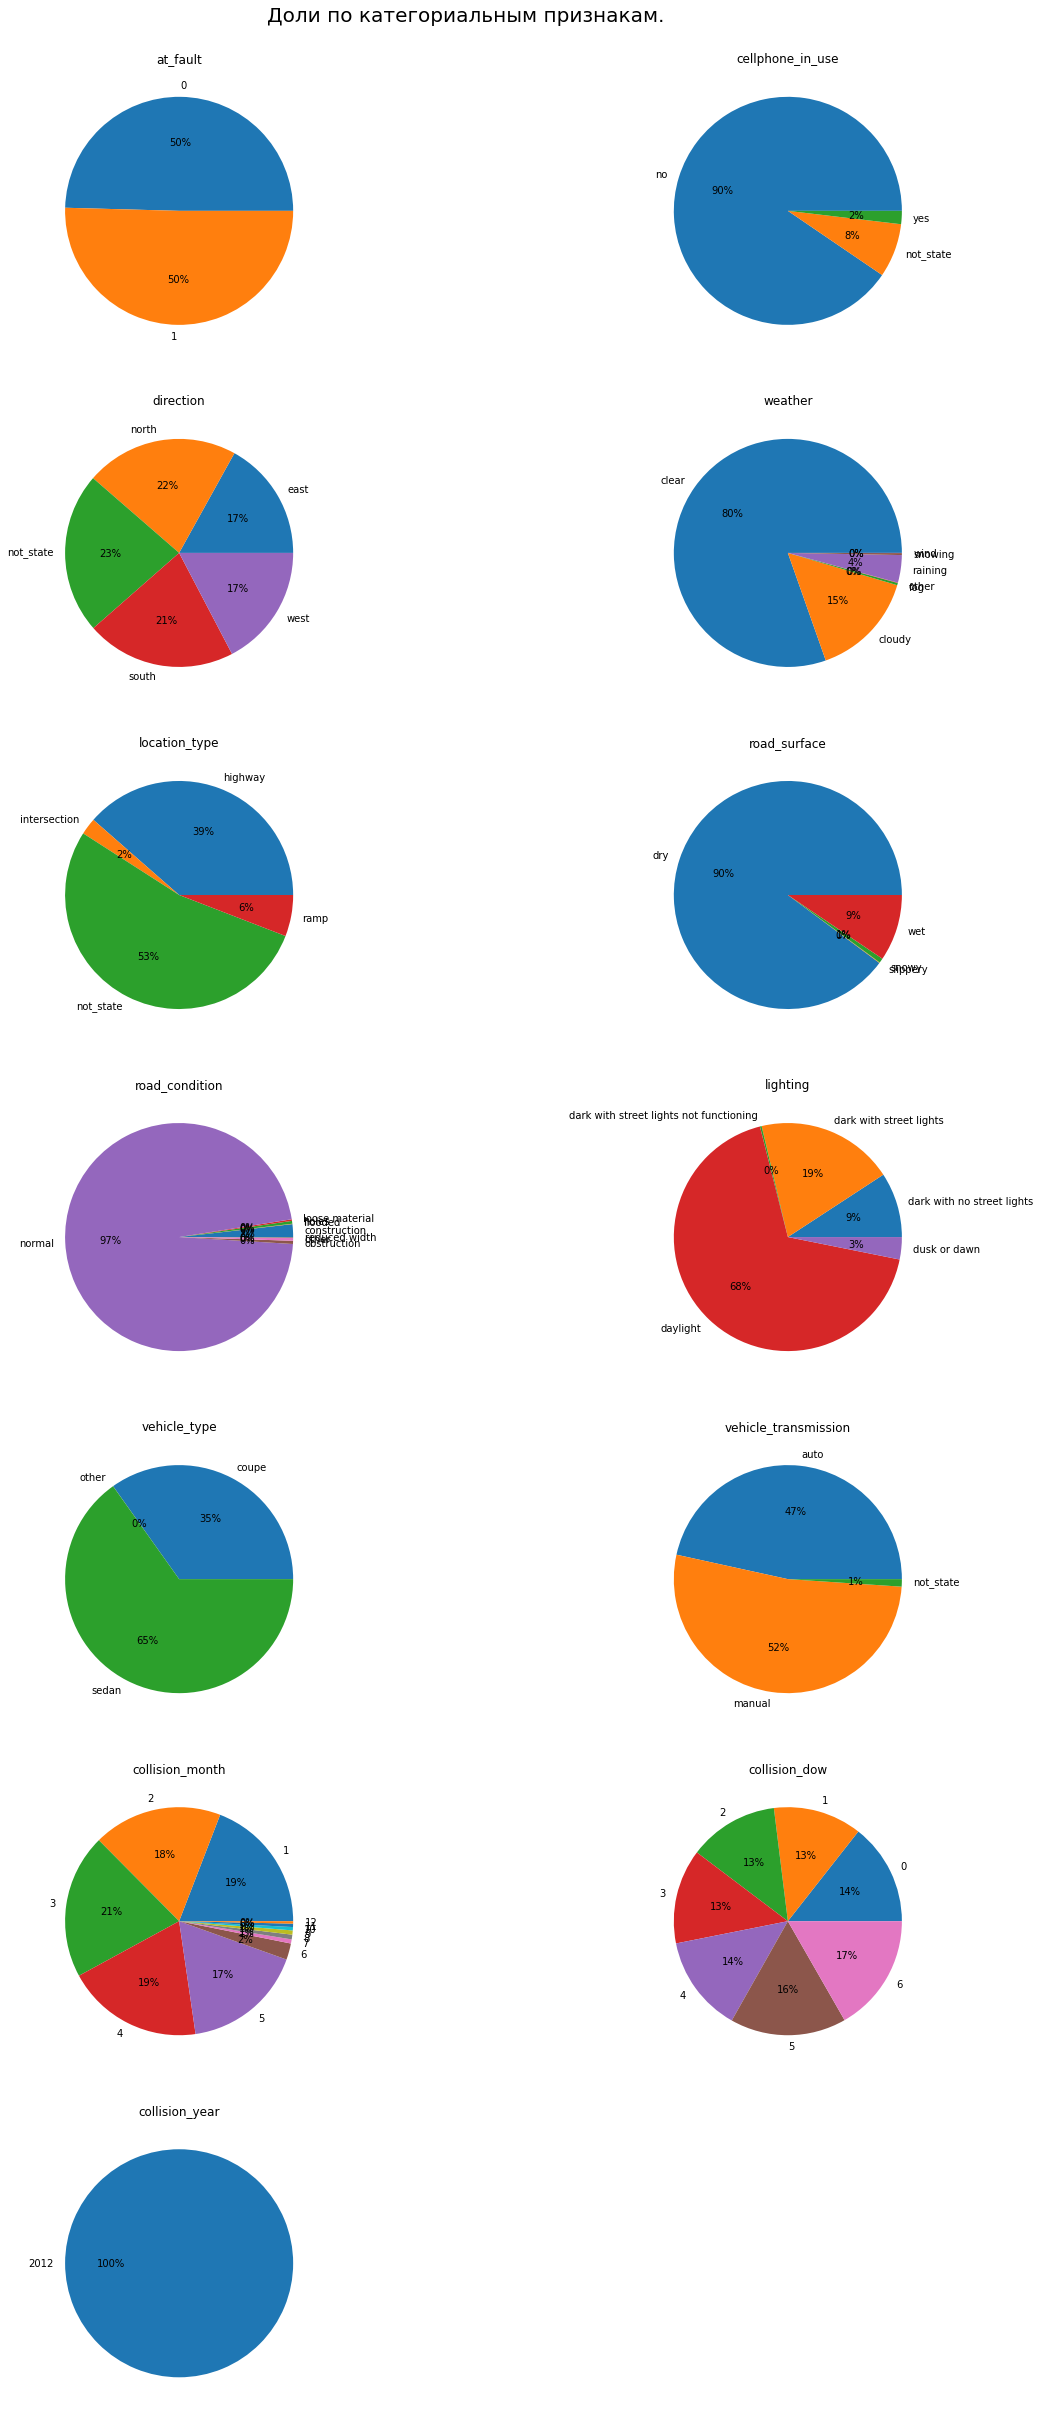

In [40]:
categorical_property_visualization(
    data_= crash_df.reset_index(),
    indexes_ = cat_column_lst,
    titles_ =  cat_column_lst,
    values_ = 'vehicles_id',
    aggfunc_='count',
    title_ = 'Доли по категориальным признакам.',
    figsize_=(20, 43),
#    nrows_= 8,
    ncols_= 2,
    y_title_ = 0.9)

### Объединение значений: удаление записей, исключение пробелов, объединение значений.

In [41]:
#Поле -   party_drug_physical
#crash_df['party_drug_physical'].replace(
#        {
#            'under drug influence': 'bad',
#            'impairment - physical': 'bad',
#            'sleepy/fatigued': 'bad',
#            'G': 'not_state',
#            'not applicable': 'not_state'
#        }, 
#        inplace = True
#                          )

#Поле - lighting
crash_df['lighting'].replace(to_replace='dark with street lights not functioning', value='dark with no street lights', inplace = True)


# Поле -   weather
crash_df['weather'].replace(
        {
            'fog': 'low_visibility',
            'raining': 'low_visibility',
            'snowing': 'low_visibility',
            'cloudy': 'low_visibility'
        }, 

        inplace = True
                          )

crash_df = crash_df.loc[~crash_df['weather'].isin(['other', 'wind'])]

# Поле - road_condition
crash_df['road_condition'].replace(
        {
            'construction': 'abnormal',
            'flooded': 'abnormal',
            'holes': 'abnormal',
            'loose material': 'abnormal',
            'obstruction': 'abnormal',
            'other': 'abnormal',
            'reduced width': 'abnormal'
        }, 

        inplace = True
                          )
# Поле - road_surface
crash_df['road_surface'].replace(
        {
            'slippery': 'wet',
            'snowy': 'wet'
        }, 

        inplace = True
                          )

# Поле -   vehicle_type
crash_df['vehicle_type'].replace(
        {
            'hatchback': 'hatchback_minivan',
            'minivan': 'hatchback_minivan'
        }, 

        inplace = True
                          )

crash_df = crash_df.loc[~crash_df['vehicle_type'].isin(['other'])]
crash_df = crash_df.loc[~(crash_df['vehicle_transmission'] == 'not_state')]

### Формирование новых признаков

In [42]:
# 0 - 'day_off', 1 - weekday
crash_df['collision_dow_type'] = crash_df['collision_dow'].apply(lambda x: 0 if x in([0, 1]) else 1)
cat_column_lst.append('collision_dow_type')

# 0 до 6 часов — ночь, с 6 до 12 часов — утро, с 12 до 18 часов — день, с 18 до 24 часов — вечер.
crash_df['collision_day_part'] = crash_df['collision_hour'].apply(get_day_part)
cat_column_lst.append('collision_day_part')

drop_lst = [
        'collision_year',
        'collision_dow',
        'collision_hour'    
]

cat_column_lst = list(set(cat_column_lst) - set(drop_lst))
    
crash_df.drop(
    drop_lst,
    axis = 1,
    inplace = True)

print(cat_column_lst)

['collision_dow_type', 'lighting', 'location_type', 'weather', 'vehicle_type', 'direction', 'road_surface', 'road_condition', 'vehicle_transmission', 'at_fault', 'cellphone_in_use', 'collision_day_part', 'collision_month']


### Визуализация после внесения изменений

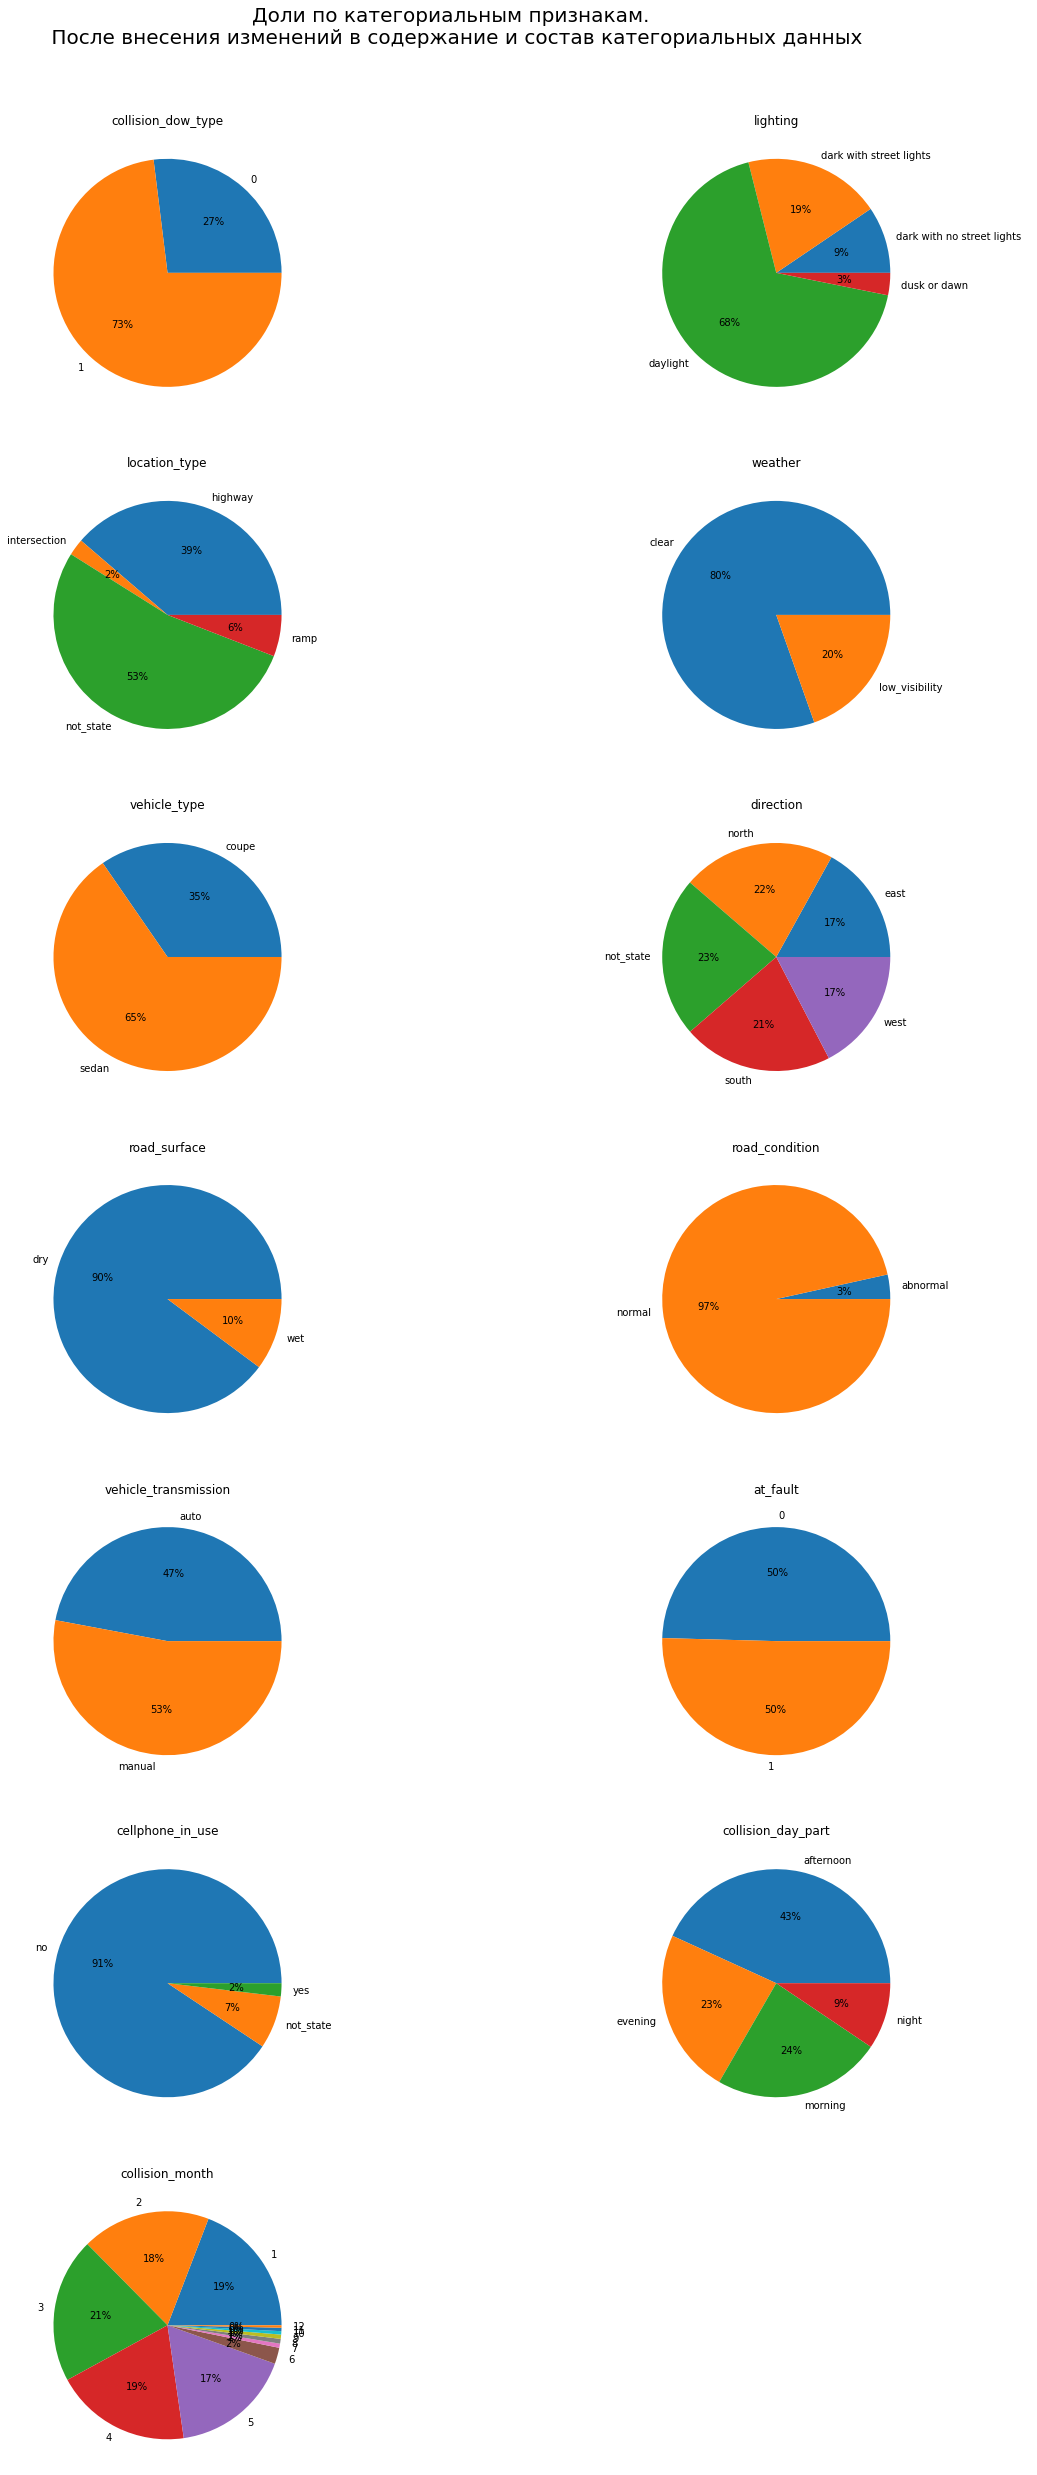

In [43]:
categorical_property_visualization(
    data_= crash_df.reset_index(),
    indexes_ = cat_column_lst,
    titles_ =  cat_column_lst,
    values_ = 'vehicles_id',
    aggfunc_='count',
    title_ = 'Доли по категориальным признакам. \n После внесения изменений в содержание и состав категориальных данных',
    figsize_=(20, 43),
    ncols_= 2,
    y_title_ = 0.92)

### **`Выводы`**

* Группировка по значениям показывает существование небольших групп в составе признаков.
* Для эффективного использования этих признаков в работе модели внесены следующие изменения:
<br>

    * `weather`
|Оригинальное значение|Новое значение|
|---------------------|--------------|
|fog|low_visibility|
|raining|low_visibility|
|snowing|low_visibility|
|cloudy|low_visibility|

    * `road_condition`
|Оригинальное значение|Новое значение|
|---------------------|--------------|
|construction|abnormal|
|flooded|abnormal|
|holes|abnormal
|loose material|abnormal|
|obstruction|abnormal|
|other|abnormal|
|reduced width|abnormal|

    * `road_surface`
|Оригинальное значение|Новое значение|
|---------------------|--------------|
|slippery|wet|
|snowy|wet|

    * `vehicle_type`
|Оригинальное значение|Новое значение|
|---------------------|--------------|
|hatchback|hatchback_minivan|
|minivan|hatchback_minivan|

    * Удалены записи, содержащие значения `not_state` в признаках `vehicle_type` и `vehicle_transmission`.
* Сформированы новые признаки:
    * `collision_dow_type` - night, morning, afternoon, evening
    * `collision_day_part` - 0, 1 (выходные, будни)

In [44]:
duplicates_df, final_shape_df = df_inf(crash_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------- 
 Имя: Не определено 

 Не определено (первые 3 строк) 


,vehicles_id,parties_id,case_id,at_fault,insurance_premium,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,collision_month,vehicle_type,vehicle_transmission,vehicle_age,collision_dow_type,collision_day_part
0,1463632,2657076,5599528,0,34.0,had not been drinking,no,west,clear,highway,dry,normal,daylight,4,sedan,auto,4.0,1,afternoon
1,1463713,2657345,5599684,0,46.0,had not been drinking,no,south,clear,not_state,dry,normal,daylight,4,sedan,auto,2.0,0,afternoon
2,1463913,2657829,5599941,1,38.0,"had been drinking, under influence",no,east,clear,intersection,dry,abnormal,dark with no street lights,5,sedan,auto,5.0,1,night



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53850 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicles_id           53850 non-null  int64  
 1   parties_id            53850 non-null  int64  
 2   case_id               53850 non-null  object 
 3   at_fault              53850 non-null  int64  
 4   insurance_premium     53436 non-null  float64
 5   party_sobriety        53032 non-null  object 
 6   cellphone_in_use      53850 non-null  object 
 7   direction             53850 non-null  object 
 8   weather               53689 non-null  object 
 9   location_type         53850 non-null  object 
 10  road_surface          53526 non-null  object 
 11  road_condition        53615 non-null  object 
 12  lighting              53702 non-null  object 
 13  collision_month       53850 non-null  int64  
 14  vehicle_type          53850 non-null  object 
 15  veh

,vehicles_id,parties_id,at_fault,insurance_premium,collision_month,vehicle_age,collision_dow_type
count,5.385000e+04,5.385000e+04,53850.000000,53436.000000,53850.000000,53850.000000,53850.000000
mean,1.429274e+06,2.594685e+06,0.504271,37.620518,3.238292,4.851866,0.730455
std,5.442921e+04,9.882823e+04,0.499986,16.345926,1.812581,3.236330,0.443728
min,9.855270e+05,1.800807e+06,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.386493e+06,2.517409e+06,0.000000,24.000000,2.000000,3.000000,0.000000
50%,1.432074e+06,2.598449e+06,1.000000,34.000000,3.000000,4.000000,1.000000
75%,1.476191e+06,2.681243e+06,1.000000,49.000000,4.000000,7.000000,1.000000
max,1.517653e+06,2.752381e+06,1.000000,105.000000,12.000000,161.000000,1.000000



 Описание не числовых полей:  


,case_id,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,vehicle_type,vehicle_transmission,collision_day_part
count,53850,53032,53850,53850,53689,53850,53526,53615,53702,53850,53850,53850
unique,43108,6,3,5,2,4,2,2,4,2,2,4
top,5542351,had not been drinking,no,not_state,clear,not_state,dry,normal,daylight,sedan,manual,afternoon
freq,8,46642,48820,12226,43175,28562,48076,51759,36469,35211,28512,23255



 Пропуски:  


vehicles_id               0
parties_id                0
case_id                   0
at_fault                  0
insurance_premium       414
party_sobriety          818
cellphone_in_use          0
direction                 0
weather                 161
location_type             0
road_surface            324
road_condition          235
lighting                148
collision_month           0
vehicle_type              0
vehicle_transmission      0
vehicle_age               0
collision_dow_type        0
collision_day_part        0
dtype: int64


 Доля записей, содержащих пропуски:  3.47 %
 Дубликаты не обнаружены! 
 


## **`Числовые признаки`**

### Изменение типов данных.

In [45]:
crash_df['at_fault'] = crash_df['at_fault'].astype('Int64')
crash_df['vehicle_age'] = crash_df['vehicle_age'].astype('Int64')

### Анализ значений

---------------------------------------------------------------------------------------------------------
 Поле : vehicle_age - vehicle_age 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    53850.000000
mean         4.851866
std          3.236330
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64


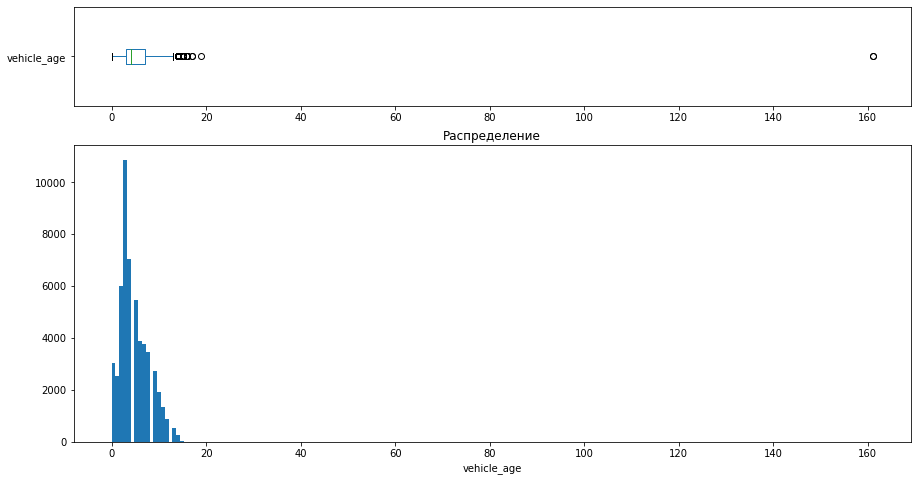

In [46]:
indexes = [
#    'distance',
#    'insurance_premium'
    'vehicle_age'
]

titles = [
#    'distance',
#    'insurance_premium'
    'vehicle_age'
]

kde_plot_log_flag = []

hue_lst = []

index = 0
for column in indexes:
    column_analiser(
        crash_df,
        column,
        x_label = titles[index],
        y_label = '',
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 8),
        height_ratios_ = [1, 3],
        hue_lst_ = [], #hue_lst,
        kde_plot_log_flag_ = 0,
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = titles[index],
        kde_plot_y_label = 'Распределение.'
)
    index += 1

### Удаление аномалий

### Анализ значений после удаления аномалий

### Перевод id - полей в индексы

In [47]:
crash_df.set_index(
    ['vehicles_id', 'parties_id', 'case_id'],
    inplace = True
                  )

In [48]:
# Анализ датасета после установки индексов
duplicates_df, final_shape_df = df_inf(crash_df, head_row = 3, drop_duplicates_flag = True)

 ------------------------------------------------------------------------- 
 Имя: Не определено 

 Не определено (первые 3 строк) 


,,,at_fault,insurance_premium,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,collision_month,vehicle_type,vehicle_transmission,vehicle_age,collision_dow_type,collision_day_part
vehicles_id,parties_id,case_id,,,,,,,,,,,,,,,,
1463632,2657076,5599528,0,34.0,had not been drinking,no,west,clear,highway,dry,normal,daylight,4,sedan,auto,4,1,afternoon
1463713,2657345,5599684,0,46.0,had not been drinking,no,south,clear,not_state,dry,normal,daylight,4,sedan,auto,2,0,afternoon
1463913,2657829,5599941,1,38.0,"had been drinking, under influence",no,east,clear,intersection,dry,abnormal,dark with no street lights,5,sedan,auto,5,1,night



 Информация:  
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53850 entries, (1463632, 2657076, '5599528') to (1373130, 2493017, '5501308')
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              53850 non-null  Int64  
 1   insurance_premium     53436 non-null  float64
 2   party_sobriety        53032 non-null  object 
 3   cellphone_in_use      53850 non-null  object 
 4   direction             53850 non-null  object 
 5   weather               53689 non-null  object 
 6   location_type         53850 non-null  object 
 7   road_surface          53526 non-null  object 
 8   road_condition        53615 non-null  object 
 9   lighting              53702 non-null  object 
 10  collision_month       53850 non-null  int64  
 11  vehicle_type          53850 non-null  object 
 12  vehicle_transmission  53850 non-null  object 
 13  vehicle_age           53850 non-null  Int64  
 14  co

,at_fault,insurance_premium,collision_month,vehicle_age,collision_dow_type
count,53850.000000,53436.000000,53850.000000,53850.000000,53850.000000
mean,0.504271,37.620518,3.238292,4.851866,0.730455
std,0.499986,16.345926,1.812581,3.236330,0.443728
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,24.000000,2.000000,3.000000,0.000000
50%,1.000000,34.000000,3.000000,4.000000,1.000000
75%,1.000000,49.000000,4.000000,7.000000,1.000000
max,1.000000,105.000000,12.000000,161.000000,1.000000



 Описание не числовых полей:  


,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,vehicle_type,vehicle_transmission,collision_day_part
count,53032,53850,53850,53689,53850,53526,53615,53702,53850,53850,53850
unique,6,3,5,2,4,2,2,4,2,2,4
top,had not been drinking,no,not_state,clear,not_state,dry,normal,daylight,sedan,manual,afternoon
freq,46642,48820,12226,43175,28562,48076,51759,36469,35211,28512,23255



 Пропуски:  


at_fault                  0
insurance_premium       414
party_sobriety          818
cellphone_in_use          0
direction                 0
weather                 161
location_type             0
road_surface            324
road_condition          235
lighting                148
collision_month           0
vehicle_type              0
vehicle_transmission      0
vehicle_age               0
collision_dow_type        0
collision_day_part        0
dtype: int64


 Доля записей, содержащих пропуски:  3.47 %
 
 Количество дубликатов: 2041 
 Дубликаты (первые 3 строк) 


,,,at_fault,insurance_premium,party_sobriety,cellphone_in_use,direction,weather,location_type,road_surface,road_condition,lighting,collision_month,vehicle_type,vehicle_transmission,vehicle_age,collision_dow_type,collision_day_part
vehicles_id,parties_id,case_id,,,,,,,,,,,,,,,,
1326388,2406253,5454784,1,19.0,had not been drinking,no,south,clear,highway,dry,normal,daylight,1,sedan,auto,3,1,morning
1333450,2419631,5461960,1,19.0,had not been drinking,no,south,low_visibility,not_state,wet,normal,daylight,1,sedan,manual,2,0,afternoon
1359975,2468162,5487998,1,23.0,had not been drinking,no,west,clear,not_state,dry,normal,daylight,2,sedan,manual,4,0,afternoon


 Дубликаты удалены! 
 Количество дубликатов после удаления: 0 
 


In [49]:
# Удалено записей
#print(original_shape_df)
#print(final_shape_df)

print(
    blue_start,
        'Удалено ',
    color_end,
    round((original_shape_df[0] - final_shape_df[0]) / original_shape_df[0], 3) * 100,
    '%',
    blue_start,
        'записей',
    color_end
     )

 Удалено   4.3 %  записей 


## Формирование финального датасета для построения модели

In [50]:
target_field = ['at_fault']

num_field = [
#    'distance',
#    'insurance_premium',
    'vehicle_age'
]
#cat_field = set(cat_column_lst) - set(target_field)

cat_field = [
#    'party_sobriety',
    'direction',
    'weather',
    'road_surface',
    'road_condition',
    'lighting',
    'collision_month',
    'collision_dow_type',
    'collision_day_part',
    'location_type',
    'vehicle_type',
    'vehicle_transmission'
]

fich_field_lst = []
fich_field_lst.extend(num_field)
fich_field_lst.extend(cat_field)

all_field_lst = []
all_field_lst.extend(fich_field_lst)
all_field_lst.extend(target_field)

In [51]:
crash_final_df = crash_df[all_field_lst]
crash_final_df.name = 'crash_final_df'
duplicates_df, final_shape_df = df_inf(crash_final_df, head_row = 3, drop_duplicates_flag = True)

 ------------------------------------------------------------------------- 
 Имя: crash_final_df 

 crash_final_df (первые 3 строк) 


,,,vehicle_age,direction,weather,road_surface,road_condition,lighting,collision_month,collision_dow_type,collision_day_part,location_type,vehicle_type,vehicle_transmission,at_fault
vehicles_id,parties_id,case_id,,,,,,,,,,,,,
1463632,2657076,5599528,4,west,clear,dry,normal,daylight,4,1,afternoon,highway,sedan,auto,0
1463713,2657345,5599684,2,south,clear,dry,normal,daylight,4,0,afternoon,not_state,sedan,auto,0
1463913,2657829,5599941,5,east,clear,dry,abnormal,dark with no street lights,5,1,night,intersection,sedan,auto,1



 Информация:  
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51809 entries, (1463632, 2657076, '5599528') to (1373130, 2493017, '5501308')
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   vehicle_age           51809 non-null  Int64 
 1   direction             51809 non-null  object
 2   weather               51648 non-null  object
 3   road_surface          51485 non-null  object
 4   road_condition        51575 non-null  object
 5   lighting              51661 non-null  object
 6   collision_month       51809 non-null  int64 
 7   collision_dow_type    51809 non-null  int64 
 8   collision_day_part    51809 non-null  object
 9   location_type         51809 non-null  object
 10  vehicle_type          51809 non-null  object
 11  vehicle_transmission  51809 non-null  object
 12  at_fault              51809 non-null  Int64 
dtypes: Int64(2), int64(2), object(9)
memory usage: 12.0+ MB

 Описание ч

,vehicle_age,collision_month,collision_dow_type,at_fault
count,51809.000000,51809.000000,51809.000000,51809.000000
mean,4.883978,3.242352,0.724642,0.505356
std,3.258937,1.825349,0.446699,0.499976
min,0.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,0.000000,0.000000
50%,4.000000,3.000000,1.000000,1.000000
75%,7.000000,4.000000,1.000000,1.000000
max,161.000000,12.000000,1.000000,1.000000



 Описание не числовых полей:  


,direction,weather,road_surface,road_condition,lighting,collision_day_part,location_type,vehicle_type,vehicle_transmission
count,51809,51648,51485,51575,51661,51809,51809,51809,51809
unique,5,2,2,2,4,4,4,2,2
top,not_state,clear,dry,normal,daylight,afternoon,not_state,sedan,manual
freq,11498,41221,46080,49723,34745,21953,27307,34087,27424



 Пропуски:  


vehicle_age               0
direction                 0
weather                 161
road_surface            324
road_condition          234
lighting                148
collision_month           0
collision_dow_type        0
collision_day_part        0
location_type             0
vehicle_type              0
vehicle_transmission      0
at_fault                  0
dtype: int64


 Доля записей, содержащих пропуски:  1.33 %
 
 Количество дубликатов: 16638 
 Дубликаты (первые 3 строк) 


,,,vehicle_age,direction,weather,road_surface,road_condition,lighting,collision_month,collision_dow_type,collision_day_part,location_type,vehicle_type,vehicle_transmission,at_fault
vehicles_id,parties_id,case_id,,,,,,,,,,,,,
1338844,2429577,5467253,3,north,clear,dry,normal,daylight,1,1,afternoon,highway,sedan,auto,0
1339320,2430432,5467724,1,north,clear,dry,normal,daylight,1,1,afternoon,highway,sedan,manual,0
1352012,2453295,5480077,2,east,clear,dry,normal,daylight,1,1,afternoon,highway,sedan,auto,1


 Дубликаты удалены! 
 Количество дубликатов после удаления: 0 
 


In [52]:
print(
    blue_start,
        'Удалено ',
    color_end,
    round((original_shape_df[0] - final_shape_df[0]) / original_shape_df[0], 2) * 100,
    '%',
    blue_start,
        'записей',
    color_end
     )

 Удалено   8.0 %  записей 


### ***`Выводы`***

* Во время оформления аренды известны значения двух числовых признаков:
    * ~`vehicle_age` - возраст автомобиля. Удалена запись, содеоржащая аномальное значение `161 год`.~
    * Возраст 75% автомобилей `<= 7лет`.
    * ~insurance_premium - стоимость страховки. Диапазон значений признака 0 <= Х <= 105.~
    * После перевода полей `vehicles_id, parties_id и case_id` в индексы, по результатам проверки на дубликаты удалено 8% записей.


## Корреляционный анализ

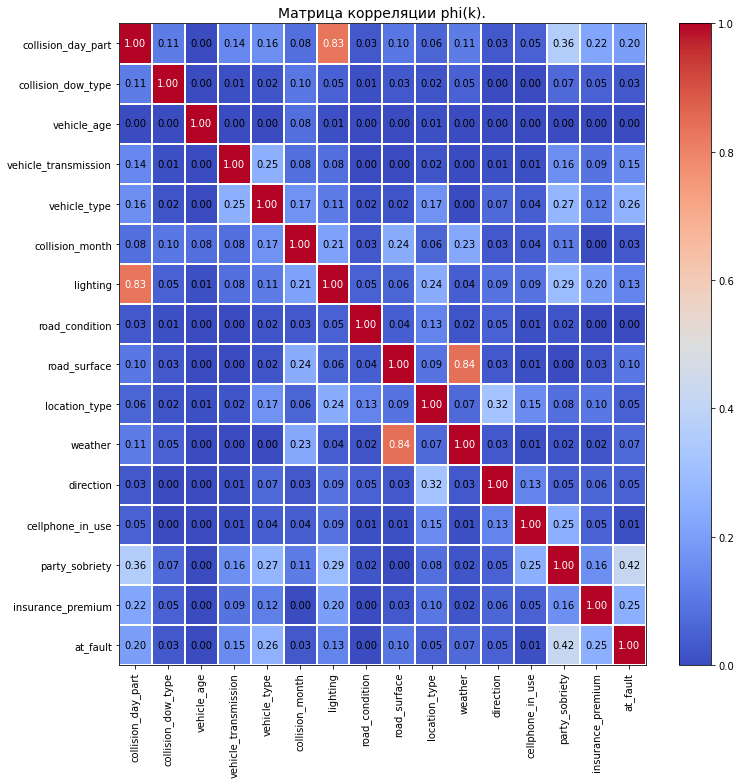

In [53]:
interval_cols_ = ['vehicle_age']

phik_date = crash_df.phik_matrix(interval_cols = interval_cols_).round(2)

plot_correlation_matrix(phik_date.values, 
                        x_labels = phik_date.columns, 
                        y_labels = phik_date.index, 
                        vmin = 0,
                        vmax = 1,
                        color_map = "coolwarm", 
                        title = 'Матрица корреляции phi(k).', 
                        fontsize_factor = 1, 
                        figsize = (11, 11));
plt.tight_layout()
plt.show()

### `**Выводы**`

* Признаков мультиколлинеарности не выявлено.
* Высокая корреляция признаков:
    * `collision_day_part` и `lighting`
    * `weather` и `road_surface`
    * ~`insurance_premium`  и `vehicle_age`~

# **`Разработка модели оценки водительского риска`**

## Разделение на выборки

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    crash_final_df.drop(target_field, axis = 1),
    crash_final_df[target_field],    
    test_size = 0.2,
    shuffle = True,
    random_state = RANDOM_STATE)

## Пайплайн подготовки категориальных признаков: заполнение пропусков и кодирование

In [55]:
# Пайплайн подготовки признаков num_field b cat_field: заполнение пропусков и кодирование
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
        ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)),
        ('simpleImputer_after_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ])

num_pipe = Pipeline([
    ('imp_num', SimpleImputer(missing_values = np.nan, strategy='mean')),
    ('scale', StandardScaler()),
])

# Общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_field),
#     ('num', StandardScaler(), num_field)
     ('num', num_pipe, num_field)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())    
])

## Определение параметров для определения лучшей модели

In [56]:
# Определение параметров для поиска
param_dist = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [CatBoostClassifier(verbose=0, random_state = RANDOM_STATE)],
        'models__iterations': [50],
        'models__depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50],
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },    
    {
        'models': [RandomForestClassifier(random_state = RANDOM_STATE)],
        'models__n_estimators': range(10, 60, 10),
        'models__max_depth': range(2, 5),
        'models__min_samples_split': (2, 3, 4),
        'models__min_samples_leaf': (1, 2, 3, 4)
    }]

## Определение лучшей модели и значений гиперпараметров.

In [66]:
search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_dist,
    n_iter = 50,
    cv = 3,
    verbose = 1,
    scoring = 'recall',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [67]:
%%time
search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 1min 31s, sys: 1.39 s, total: 1min 32s
Wall time: 1min 41s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_frequen...
                                         'models__n_estimators': [50],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(random_state=2025)],
                                         'models__max_depth': range(2, 5),
                                         'models__min_samples_leaf': (1, 2, 3,
                                                                      4),
                                         'models__min_samples_split': (2, 3, 4),
                                         'models__n_estimators': range(10, 60, 10)}],
                   random_state=2025, scoring='recall', verbose=1)

In [69]:
# Результаты валидации
cv_results = pd.DataFrame(search.cv_results_)
cols = [
'param_models',
'params',
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'mean_test_score',
'std_test_score',
'rank_test_score'
]

In [70]:
# Три лучшие модели
cv_results[cols].sort_values('rank_test_score').head(3)

,param_models,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,RandomForestClassifier(random_state=2025),"{'models__n_estimators': 30, 'models__min_samples_split': 4, 'models__min_samples_leaf': 4, 'models__max_depth': 2, 'models': RandomForestClassifier(random_state=2025)}",0.398953,0.013397,0.095811,0.003508,0.817719,0.808350,0.794297,0.806789,0.009625,1
43,RandomForestClassifier(random_state=2025),"{'models__n_estimators': 30, 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': 2, 'models': RandomForestClassifier(random_state=2025)}",0.376711,0.008072,0.091280,0.002000,0.817719,0.808350,0.794297,0.806789,0.009625,1
39,RandomForestClassifier(random_state=2025),"{'models__n_estimators': 30, 'models__min_samples_split': 2, 'models__min_samples_leaf': 1, 'models__max_depth': 2, 'models': RandomForestClassifier(random_state=2025)}",0.405592,0.009843,0.101344,0.007589,0.817719,0.808147,0.794297,0.806721,0.009615,3


## Лучшая модель и ее параметры

In [71]:
print(blue_start, 'Лучшая модель и её параметры :\n\n', color_end, search.best_estimator_, '\n')
print(blue_start, 'Метрика лучшей модели на кросс-валидации:', color_end, round(search.best_score_, 5))

 Лучшая модель и её параметры :

  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                  

## **`Выводы`**

* Состав исследуемых алгоритмов:
    * LogisticRegression
    * CatBoostClassifier
    * LGBMClassifier
    * RandomForestClassifier
    
* Лучшая модель - `RandomForestClassifier` ~`LGBMClassifier`~, определена методом `RandomizedSearchCV`.

* Заказчик поставил задачу разработать модель прогноза риска возникновения ДТП. При этом целевой признак содержит информацию о виновности, или невиновности (at_fault 1/0) клиента каршеринга в произошедшем ДТП. Т.е. важно **точнее прогнозировать виновность** клиента (at_fault = 1) и не допускать к управлению потенциальных виновников.
* Т.к. нам важно акцентировать внимание на at_fault = 1 (виновник ДТП), была выбрана метрика `Recall`, которая измеряет, способность модели присвоить класс 1 всем объектам этого класса.

* Значение метрики `recall` = **0.80679** (Общая производительность модели бинарной классификации).

# Обучение лучшей модели на тестовой выборке

In [73]:
%%time
# Обучение лучшей модели на трейне
best_param_model = search.best_estimator_.fit(X_train, y_train)

# Формирование прогноза на тесте
y_test_predict = best_param_model.predict(X_test)
y_test_predict_proba = best_param_model.predict_proba(X_test)

CPU times: user 689 ms, sys: 7.84 ms, total: 696 ms
Wall time: 695 ms


## Расчет метрик на тестовой выборке

In [74]:
# Метрика Accuracy (точность) показывает долю правильно классифицированных объектов
# относительно общего числа объектов в наборе данных. 1
# Она принимает значения в диапазоне от 0 до 1 (или от 0% до 100%). 
# Чем ближе значение Accuracy к 1 (или 100%), тем лучше работает алгоритм классификации.
#acc = accuracy_score(y_test, y_test_predict)
#print(blue_start, 'Accuracy = ', color_end, round(acc, 4))

# Значение ROC-AUC колеблется от 0 до 1. 1 соответствует идеальному классификатору
#roc_auc = roc_auc_score(y_test, y_test_predict_proba[:, 1]) #y_test_predict
#print(blue_start, 'ROC-AUC =', color_end, round(roc_auc, 4))

# Метрика F1 (F-мера) показывает, насколько хорошо модель распознаёт положительные случаи,
# минимизируя ошибочно положительные и ошибочно отрицательные предсказания.
f1 = f1_score(y_test, y_test_predict, pos_label = 1)
print(blue_start, 'F1 =', color_end, round(f1, 4)) 

### Метрика Recall (полнота) показывает, 
# какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.
recall = recall_score(y_test, y_test_predict, pos_label = 1)
print(blue_start, 'Recall =', color_end, round(recall, 4))

# Precision (точность) показывает: сколько реальных объектов класса среди всех тех, что классификатор отнес к этому классу.
precision = precision_score(y_test, y_test_predict, pos_label = 1)
print(blue_start, 'Precision =', color_end, round(precision, 4))

 F1 =  0.6698
 Recall =  0.8202
 Precision =  0.566


## График Precision-Recall

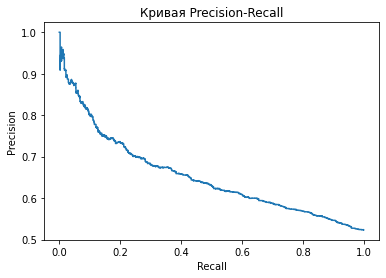

In [76]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_predict_proba[:, 1])
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Кривая Precision-Recall')
plt.show()

## Матрица ошибок

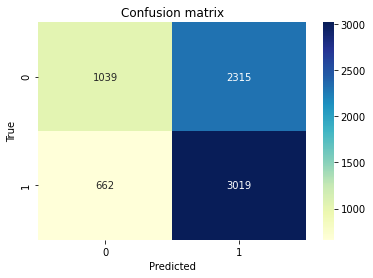

In [77]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_test_predict)

cm_matrix = pd.DataFrame(
    data = cm
#    columns=['Actual Positive(1)', 'Actual Negative(0)'],
#    index=['Predict Positive(1)', 'Predict Negative(0)']
                        )

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.title('Confusion matrix')
plt.show()

## **`Выводы`**

* Тестовая выборка состоит из `7035` наблюдений:
    * `3681` - виновен
    * `3354` - невиновен
* Значение метрик на тестовой выборке:
    * **F1** =  `0.6698` - среднее гармоническое между precision и recall. F1 достигает максимального значения, когда исходные метрики равны единице. В нашем случае значение метрики не высокое, т.к. модель хорошо прогнозирует класс `виновен`, при этом плохо предсказывает класс `невиновен`.  
    * **Recall** =  `0.8202` - (полнота) Она измеряет, смогла ли модель присвоить класс 1 всем объектам этого класса. Чем выше recall, тем больше прогнозов Positive модель смогла дать верно.
    * **Precision** =  `0.566` - (точность) Эта метрика показывает точность, с которой модель присваивает объектам класс 1, то есть получает результат типа Positive. Иными словами, precision определяет, не слишком ли часто модель выставляет класс 1 объектам класса 0. Чем выше эта метрика, тем меньше таких случаев.
* Матрица ошибок показывает детальную картину производительности модели (количество правильных и ошибочных прогнозов по каждому классу):
    * **True Negatives (TN)**: `1039` случаев, когда модель **правильно предсказала невиновность** при ДТП - `31%`
    * **True Positives (TP)**: `3019` случаев, когда модель **правильно предсказала вину** при ДТП. - `82%`
    * **False Positives (FP)**: `662` случаев, когда модель **неправильно предсказала виновность** при ДТП. - `19%`
    * **False Negatives (FN)**: `2315` случая, когда модель **неправильно предсказала невиновность** при ДТП. - `63%`<br>
* Резюме по матрице ошибок:
    * Правильных прогнозов - 1039 + 3019 = 4058 - **58%**
    * Ошибочных прогнозов - 662 + 2315 = 2977 - **42%**
    * Модель лучше прогнозирует **виновность** при ДТП - `84%` правильных прогнозов. Правильных ответов по прогнозу невиновности - `28%.`
* **Значения метрик и графическое представление говорят о том, что модель далека от идеала. И ориентирована на прогноз `виновности` в ДТП**

# Анализ важности факторов ДТП

## Значения важности факторов.

,Feature,Importance
10,vehicle_type,0.070056
0,vehicle_age,0.014385
8,collision_day_part,0.008812
3,road_surface,0.007466
1,direction,0.006002
11,vehicle_transmission,0.005430
5,lighting,0.001667
9,location_type,0.001211
7,collision_dow_type,0.000248
4,road_condition,0.000104


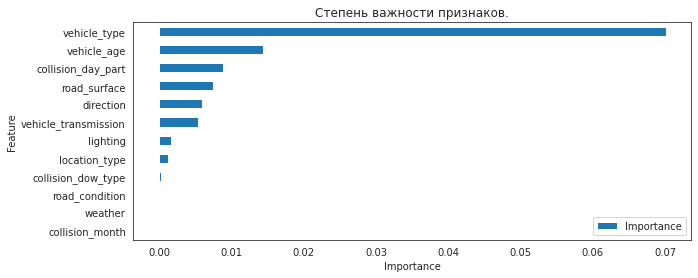

In [88]:
# Формирование таблицы факторов
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': result['importances_mean']})
display(feature_importance.sort_values('Importance', ascending = False))

# Формирование графика
feature_importance = feature_importance.sort_values('Importance', ascending = True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 4));
plt.title('Степень важности признаков.')
plt.xlabel("Importance")
plt.show()

## Анализ важнейшего фактора - степень опьянения (party_sobriety)

### Распределение количества ДТП по степени опъянения в разрезе виновен / невиновен. (Факт и Прогноз)

In [91]:
# Объединение факта и прогноза в один датафрейм
X_test['Прогноз'] = y_test_predict
X_test['Факт'] = y_test

In [93]:
collisions_inf_df = X_test.groupby(
#    ['party_sobriety',
    ['vehicle_type',
    'Факт']
                                       ).agg(
        ['count']
                                            )['vehicle_age'].reset_index()


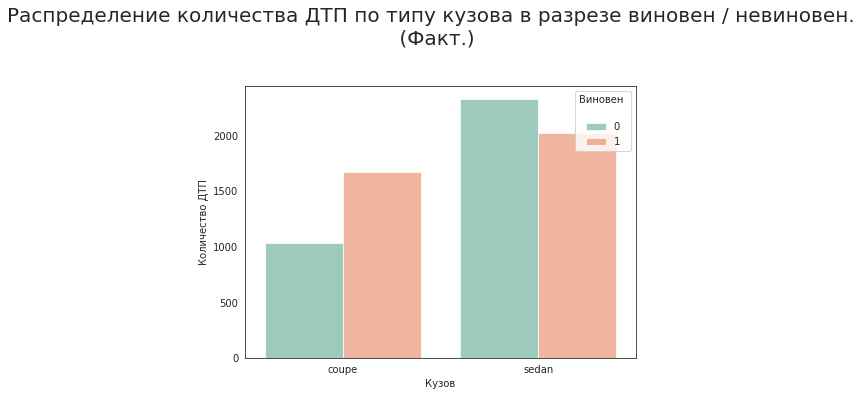

In [95]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Распределение количества ДТП по типу кузова в разрезе виновен / невиновен. \n (Факт.)',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Виновен \n',
    x_rotation_ = 0,
#    x_field_ = 'party_sobriety',
    x_field_ = 'vehicle_type',
    y_field_ = 'count',
    x_label_ = 'Кузов',
    y_label_ = 'Количество ДТП',
    hue_field_ = 'Факт'
)

In [96]:
collisions_inf_df = X_test.groupby(
#    ['party_sobriety',
    ['vehicle_type',
    'Прогноз']
                                       ).agg(
        ['count']
                                            )['vehicle_age'].reset_index()


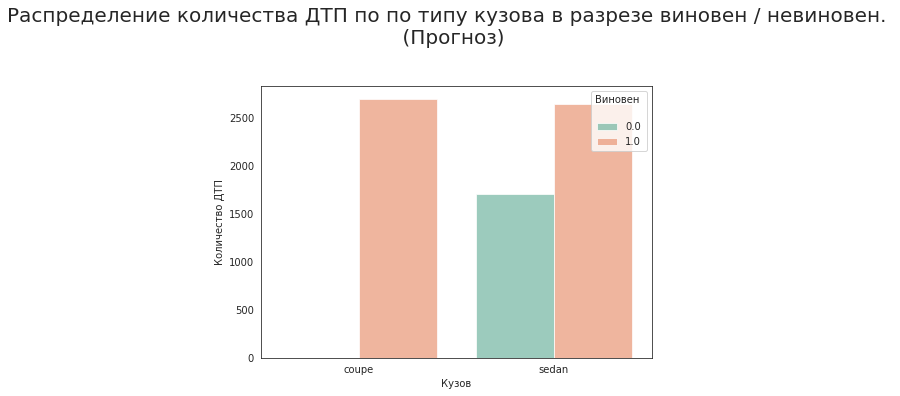

In [97]:
num_fich_by_hue_visualisation(
    collisions_inf_df,
    figsize_ = (7, 5),
    title_ = 'Распределение количества ДТП по по типу кузова в разрезе виновен / невиновен. \n (Прогноз)',
    title_fontsize_ = 20,
    y_title_ = 1.1,
    legend_title_ = 'Виновен \n',
    x_rotation_ = 0,
    x_field_ = 'vehicle_type',
    y_field_ = 'count',
    x_label_ = 'Кузов',
    y_label_ = 'Количество ДТП',
    hue_field_ = 'Прогноз'
)

## ** `Выводы`**

* Основные факторы, влияющие на работу модели в порядке убывания важности:
    * vehicle_type
    * collision_day_part
    * vehicle_age
    * direction
    * vehicle_transmission
    * road_surface
    * location_type
* Анализ значимости факторов указывает на то, что основной фактор виновности/невиновности в ДТП - `тип кузова`. Чаще происходят ДТП с участием седанов.

## Выводы

* Заказчик определил 2012 год как наиболее подходящий для построения модели. Анализ предоставленных данных показал, что наиболее полный объем данных содержится для периода с **2009 по 2011** год включительно. **Модель формировалась и тестировалась по 2012 году.**
* В предоставленных данных содержалась информация об автомобилях, ДТП и учасниках ДТП. **Значения большого количества факторов определялись в процессе оформления ДТП. Использовать эти факторы для построение модели не целесообразно.**
* **Выбор факторов обусловлен возможностью определения их значения во время оформления аренда автомобиля и требованиями заказчика.**
<br>
* Заказчик поставил задачу разработать модель прогноза риска возникновения ДТП. При этом целевой признак содержит информацию о виновности, или невиновности (at_fault 1/0) клиента каршеринга в произошедшем ДТП. Т.е. важно **точнее прогнозировать виновность** клиента (at_fault = 1) и не допускать к управлению потенциальных виновников.
* Т.к. нам важно акцентировать внимание на at_fault = 1 (виновник ДТП), была выбрана метрика `Recall`, которая измеряет, способность модели присвоить класс 1 всем объектам этого класса.
  
* Лучшая модель сформированна по предоставленным данным - `RandomForestClassifier`
    * Значение метрик на тестовой выборке:
    * **F1** =  `0.6698` - среднее гармоническое между precision и recall. F1 достигает максимального значения, когда исходные метрики равны единице. В нашем случае значение метрики не высокое, т.к. модель хорошо прогнозирует класс `виновен`, при этом плохо предсказывает класс `невиновен`.  
    * **Recall** =  `0.8202` - (полнота) Она измеряет, смогла ли модель присвоить класс 1 всем объектам этого класса. Чем выше recall, тем больше прогнозов Positive модель смогла дать верно.
    * **Precision** =  `0.566` - (точность) Эта метрика показывает точность, с которой модель присваивает объектам класс 1, то есть получает результат типа Positive. Иными словами, precision определяет, не слишком ли часто модель выставляет класс 1 объектам класса 0. Чем выше эта метрика, тем меньше таких случаев.
    * Модель лучше прогнозирует **виновность** при ДТП - `82%` правильных прогнозов. Правильных ответов по прогнозу невиновности - `31%.`
* **Значения метрик и графическое представление говорят о том, что модель далека от идеала. И ориентирована на прогноз `виновности` в ДТП**
<br>

* **Для формирования более точного прогноза я бы добавил три группы факторов:**
    * Характеристики водителя:
        * Количество нарушений
        * Количество ДТП
        * Стаж вождения
        * Возраст
        * Пол
    * Характеристики автомобиля
        * К предоставленным данным полезно добавить мощность
    * Характеристики маршрута
        * Количество регулируемых перекрестков
        * Количество нерегулируемых перекрестков
        * Средняя скорость
        * Время в пути

* **Для разработки модели, прогнозирующей вероятность ДТП (задача проекта), необходимы данные о безаварийных поездках и поездках с ДТП. В предоставленных данных нет информации о безаварийных поездках. Сформированная модель прогнозирует виновность/невиновность клиента в ДТП**